In [58]:
import h5py
import numpy as np
import pandas as pd
import os
import time
import collections
print(os.listdir("./data/train"))

['images_training.h5', 'labels_training.h5']


In [59]:
start_time = time.time()

In [60]:
with h5py.File('./data/train/images_training.h5','r') as H:
    data = np.copy(H['datatrain'])
with h5py.File('./data/train/labels_training.h5','r') as H:
    label = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.


In [61]:
levels = np.unique(label).shape[0]
label_interim = np.zeros(shape=(levels,label.shape[0]))
for i in range(label.shape[0]):
    pos = label[i]
    label_interim[pos][i] = 1
print(label_interim.shape)

(10, 30000)


In [62]:
data_train = data[0:28000,:]
label_train = label_interim[:,0:28000]
data_test = data[28000:30000,:]
label_test = label[28000:30000]

print(data_train.shape,label_train.shape,data_test.shape,label_test.shape)

(28000, 784) (10, 28000) (2000, 784) (2000,)


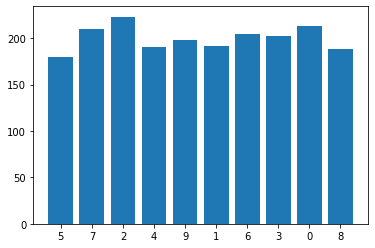

In [63]:
d = collections.Counter(label_test)

import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()))


plt.show()

In [64]:
print(data_train.max())
print(data_train.min())

1.0
0.0


#### Standardization of Training Data

In [65]:
for i in range(data_train.shape[0]):
    data_train[i] = (data_train[i]- data_train[i].mean()) / (data_train[i].std())


###### Defining the Neural Network Parameters

In [66]:
print(data_train.max())
print(data_train.min())

12.920062
-2.4185767


In [67]:
data_train = data_train.T
n_x = data_train.shape[0]
n_h1 = n_x
n_h2 = 784
n_y = levels
print(n_x,n_y)
print(label_train.shape)

784 10
(10, 28000)


###### Initializing the model parameters

In [68]:
def param_initialization(n_x, n_y, n_h1, n_h2):
    p = {}
    np.random.seed(42)
    p['W1'] = np.random.randn(n_h1,n_x) * 0.01
    p['b1'] = np.zeros(shape=(n_h1,1)) 
    p['W2'] = np.random.randn(n_h2,n_h1) * 0.01
    p['b2'] = np.zeros(shape=(n_h2,1)) 
    p['W3'] = np.random.randn(n_y,n_h2) * 0.01
    p['b3'] = np.zeros(shape=(n_y,1))
    
    return p
    
    
    

#### Activation function

In [69]:
def softmax(x):
    return np.exp(x) / sum (np.exp(x))

In [70]:
def relu(X, der =False):
    if(der):
        if X <= 0:
            return 0
        else: 
            return 1
    else:
        return np.max(X,0)

#### Implementation of Algorithm

In [71]:
def feed_forward_propagation(X, p):
    Zvals = {}
    Avals = {}
    Zvals['Z1'] = np.dot(p['W1'], X) + p['b1']
    Avals['A1'] = np.tanh(Zvals['Z1'])
    Zvals['Z2'] = np.dot(p['W2'], Avals['A1']) + p['b2']
    Avals['A2'] = np.tanh(Zvals['Z2'])
    Zvals['Z3'] = np.dot(p['W3'], Avals['A2']) + p['b3']
    Avals['A3'] = softmax(Zvals['Z3']) # Final output prediction
    
    return Zvals,Avals
     

In [72]:
def cost_computation_fn(A3, Y, batch_size):
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1 - Y), np.log(1 - A3))
    cost = - np.sum(logprobs) / batch_size
    return cost

In [73]:
def back_propagation(X, Y, Avals, p, batch_size):
    e ={}
    
    e['dZ3'] = Avals['A3'] - Y
    e['dW3'] = (1 / batch_size) * np.dot(e['dZ3'], Avals['A2'].T)
    e['db3'] = (1 / batch_size) * np.sum(e['dZ3'], axis=1, keepdims=True )
    
    e['dZ2'] = np.multiply(np.dot(p['W3'].T, e['dZ3']), 1 - np.power(Avals['A2'],2))
    e['dW2'] = (1 / batch_size) * np.dot(e['dZ2'], Avals['A1'].T)
    e['db2'] = (1 / batch_size) * np.sum(e['dZ2'], axis=1, keepdims=True)
    
    e['dZ1'] = np.multiply(np.dot(p['W2'].T, e['dZ2']),(1 - np.power(Avals['A1'],2)))
    e['dW1'] = (1 / batch_size) * np.dot(e['dZ1'], X.T)
    e['db1'] = (1 / batch_size) * np.sum(e['dZ1'], axis=1, keepdims=True)
    
    return  e

In [74]:
def params_update(p,e,l):
    p['W1'] = p['W1'] - l * e['dW1']
    p['W2'] = p['W2'] - l * e['dW2']
    p['W3'] = p['W3'] - l * e['dW3']
    p['b1'] = p['b1'] - l * e['db1']
    p['b2'] = p['b2'] - l * e['db2']
    p['b3'] = p['b3'] - l * e['db3']
    return p

###### Neural Network Training

In [75]:
params = param_initialization(n_x,n_y,n_h1,n_h2)
print(params['W1'],params['W2'],params['W3'])

[[ 0.00496714 -0.00138264  0.00647689 ... -0.01335344  0.00380198
   0.00610586]
 [ 0.0055979   0.01080781  0.00833922 ... -0.00281328  0.00066991
   0.00515939]
 [-0.01562546 -0.00529053  0.00794265 ... -0.00392013  0.01059936
   0.00617006]
 ...
 [ 0.01731378 -0.01462643 -0.00171627 ...  0.01201985  0.00710594
   0.01134593]
 [ 0.0059867   0.00035292 -0.01535515 ...  0.00840427  0.01725176
  -0.006567  ]
 [-0.00266398 -0.0116045   0.00501986 ...  0.00519815  0.00540367
   0.00256886]] [[-4.01072671e-03 -1.37401929e-02  1.11253309e-02 ... -9.39745726e-03
   8.73367471e-03 -1.63697074e-03]
 [-3.52003909e-04 -2.27137051e-02 -1.44051167e-03 ...  4.60588992e-03
  -1.03110534e-02  3.90401082e-03]
 [ 1.78516409e-02  4.30046225e-03 -1.34603462e-03 ... -5.77287094e-04
  -4.30119311e-03  1.35164389e-02]
 ...
 [ 6.21872388e-03 -2.25013939e-02 -8.00390049e-04 ...  7.91996106e-03
   3.79313205e-03  5.01927960e-03]
 [ 1.09404596e-03  2.34362260e-03  4.33454467e-03 ...  5.78541503e-03
  -8.21652056

#### Training the neural network

In [76]:
iteration = 400
batch_size = 500
learning_rate = 0.001
for j in range(iteration):
    for i in range(0, data_train.shape[1], batch_size):
    
        # Forward Propagation
        adj_weights , layer_val = feed_forward_propagation(data_train[:, i:i+batch_size], params)
     
        # Computation of Cost By Cost Entropy
    
        cost = cost_computation_fn(layer_val['A3'], label_train[:,i:i+batch_size] , batch_size)

        # Back Propagation
        errors_bp = back_propagation(data_train[:, i:i+batch_size], label_train[:,i:i+batch_size] ,layer_val, params, batch_size)

        # Updating Parameters
        params = params_update(params,errors_bp,learning_rate)
    
        print("Cost for epoch %i iteration %i : %f " %(j,i/batch_size,cost))
    

Cost for epoch 0 iteration 0 : 3.252559 
Cost for epoch 0 iteration 1 : 3.253720 
Cost for epoch 0 iteration 2 : 3.253390 
Cost for epoch 0 iteration 3 : 3.253019 
Cost for epoch 0 iteration 4 : 3.252357 
Cost for epoch 0 iteration 5 : 3.251337 
Cost for epoch 0 iteration 6 : 3.250798 
Cost for epoch 0 iteration 7 : 3.252129 
Cost for epoch 0 iteration 8 : 3.251039 
Cost for epoch 0 iteration 9 : 3.251150 
Cost for epoch 0 iteration 10 : 3.250978 
Cost for epoch 0 iteration 11 : 3.249565 
Cost for epoch 0 iteration 12 : 3.250131 
Cost for epoch 0 iteration 13 : 3.249414 
Cost for epoch 0 iteration 14 : 3.248653 
Cost for epoch 0 iteration 15 : 3.249521 
Cost for epoch 0 iteration 16 : 3.248546 
Cost for epoch 0 iteration 17 : 3.248233 
Cost for epoch 0 iteration 18 : 3.247440 
Cost for epoch 0 iteration 19 : 3.246695 
Cost for epoch 0 iteration 20 : 3.245946 
Cost for epoch 0 iteration 21 : 3.246370 
Cost for epoch 0 iteration 22 : 3.245626 
Cost for epoch 0 iteration 23 : 3.245801 
Co

Cost for epoch 3 iteration 29 : 3.187319 
Cost for epoch 3 iteration 30 : 3.187458 
Cost for epoch 3 iteration 31 : 3.185693 
Cost for epoch 3 iteration 32 : 3.182684 
Cost for epoch 3 iteration 33 : 3.181089 
Cost for epoch 3 iteration 34 : 3.184607 
Cost for epoch 3 iteration 35 : 3.182864 
Cost for epoch 3 iteration 36 : 3.184078 
Cost for epoch 3 iteration 37 : 3.181961 
Cost for epoch 3 iteration 38 : 3.186505 
Cost for epoch 3 iteration 39 : 3.182760 
Cost for epoch 3 iteration 40 : 3.181252 
Cost for epoch 3 iteration 41 : 3.177060 
Cost for epoch 3 iteration 42 : 3.180715 
Cost for epoch 3 iteration 43 : 3.179488 
Cost for epoch 3 iteration 44 : 3.184450 
Cost for epoch 3 iteration 45 : 3.182894 
Cost for epoch 3 iteration 46 : 3.176401 
Cost for epoch 3 iteration 47 : 3.177413 
Cost for epoch 3 iteration 48 : 3.178942 
Cost for epoch 3 iteration 49 : 3.179265 
Cost for epoch 3 iteration 50 : 3.178254 
Cost for epoch 3 iteration 51 : 3.178793 
Cost for epoch 3 iteration 52 : 3.

Cost for epoch 7 iteration 1 : 3.106524 
Cost for epoch 7 iteration 2 : 3.103169 
Cost for epoch 7 iteration 3 : 3.097899 
Cost for epoch 7 iteration 4 : 3.104535 
Cost for epoch 7 iteration 5 : 3.108250 
Cost for epoch 7 iteration 6 : 3.105625 
Cost for epoch 7 iteration 7 : 3.098415 
Cost for epoch 7 iteration 8 : 3.090302 
Cost for epoch 7 iteration 9 : 3.100484 
Cost for epoch 7 iteration 10 : 3.100322 
Cost for epoch 7 iteration 11 : 3.101520 
Cost for epoch 7 iteration 12 : 3.098306 
Cost for epoch 7 iteration 13 : 3.104568 
Cost for epoch 7 iteration 14 : 3.100137 
Cost for epoch 7 iteration 15 : 3.104135 
Cost for epoch 7 iteration 16 : 3.102497 
Cost for epoch 7 iteration 17 : 3.095031 
Cost for epoch 7 iteration 18 : 3.098688 
Cost for epoch 7 iteration 19 : 3.093382 
Cost for epoch 7 iteration 20 : 3.093986 
Cost for epoch 7 iteration 21 : 3.100410 
Cost for epoch 7 iteration 22 : 3.093096 
Cost for epoch 7 iteration 23 : 3.089770 
Cost for epoch 7 iteration 24 : 3.089387 
C

Cost for epoch 10 iteration 30 : 3.004562 
Cost for epoch 10 iteration 31 : 2.998218 
Cost for epoch 10 iteration 32 : 2.987399 
Cost for epoch 10 iteration 33 : 2.987663 
Cost for epoch 10 iteration 34 : 2.996512 
Cost for epoch 10 iteration 35 : 2.991573 
Cost for epoch 10 iteration 36 : 2.998797 
Cost for epoch 10 iteration 37 : 2.988568 
Cost for epoch 10 iteration 38 : 3.007718 
Cost for epoch 10 iteration 39 : 2.993322 
Cost for epoch 10 iteration 40 : 2.985570 
Cost for epoch 10 iteration 41 : 2.980226 
Cost for epoch 10 iteration 42 : 2.987315 
Cost for epoch 10 iteration 43 : 2.987324 
Cost for epoch 10 iteration 44 : 2.999554 
Cost for epoch 10 iteration 45 : 2.995481 
Cost for epoch 10 iteration 46 : 2.977020 
Cost for epoch 10 iteration 47 : 2.977966 
Cost for epoch 10 iteration 48 : 2.984423 
Cost for epoch 10 iteration 49 : 2.987471 
Cost for epoch 10 iteration 50 : 2.984111 
Cost for epoch 10 iteration 51 : 2.986730 
Cost for epoch 10 iteration 52 : 2.978074 
Cost for ep

Cost for epoch 13 iteration 55 : 2.846870 
Cost for epoch 14 iteration 0 : 2.866100 
Cost for epoch 14 iteration 1 : 2.849278 
Cost for epoch 14 iteration 2 : 2.838594 
Cost for epoch 14 iteration 3 : 2.826159 
Cost for epoch 14 iteration 4 : 2.843539 
Cost for epoch 14 iteration 5 : 2.854095 
Cost for epoch 14 iteration 6 : 2.850382 
Cost for epoch 14 iteration 7 : 2.826414 
Cost for epoch 14 iteration 8 : 2.805282 
Cost for epoch 14 iteration 9 : 2.832482 
Cost for epoch 14 iteration 10 : 2.832429 
Cost for epoch 14 iteration 11 : 2.842214 
Cost for epoch 14 iteration 12 : 2.829080 
Cost for epoch 14 iteration 13 : 2.846522 
Cost for epoch 14 iteration 14 : 2.837929 
Cost for epoch 14 iteration 15 : 2.844783 
Cost for epoch 14 iteration 16 : 2.841437 
Cost for epoch 14 iteration 17 : 2.821398 
Cost for epoch 14 iteration 18 : 2.831137 
Cost for epoch 14 iteration 19 : 2.822326 
Cost for epoch 14 iteration 20 : 2.823999 
Cost for epoch 14 iteration 21 : 2.840312 
Cost for epoch 14 ite

Cost for epoch 17 iteration 24 : 2.658740 
Cost for epoch 17 iteration 25 : 2.669406 
Cost for epoch 17 iteration 26 : 2.642125 
Cost for epoch 17 iteration 27 : 2.672723 
Cost for epoch 17 iteration 28 : 2.682401 
Cost for epoch 17 iteration 29 : 2.675155 
Cost for epoch 17 iteration 30 : 2.690259 
Cost for epoch 17 iteration 31 : 2.673768 
Cost for epoch 17 iteration 32 : 2.649976 
Cost for epoch 17 iteration 33 : 2.654790 
Cost for epoch 17 iteration 34 : 2.673905 
Cost for epoch 17 iteration 35 : 2.663963 
Cost for epoch 17 iteration 36 : 2.680167 
Cost for epoch 17 iteration 37 : 2.655881 
Cost for epoch 17 iteration 38 : 2.698826 
Cost for epoch 17 iteration 39 : 2.666252 
Cost for epoch 17 iteration 40 : 2.647864 
Cost for epoch 17 iteration 41 : 2.646357 
Cost for epoch 17 iteration 42 : 2.655573 
Cost for epoch 17 iteration 43 : 2.659483 
Cost for epoch 17 iteration 44 : 2.684350 
Cost for epoch 17 iteration 45 : 2.672040 
Cost for epoch 17 iteration 46 : 2.637518 
Cost for ep

Cost for epoch 20 iteration 48 : 2.510922 
Cost for epoch 20 iteration 49 : 2.518211 
Cost for epoch 20 iteration 50 : 2.510133 
Cost for epoch 20 iteration 51 : 2.515182 
Cost for epoch 20 iteration 52 : 2.494303 
Cost for epoch 20 iteration 53 : 2.504853 
Cost for epoch 20 iteration 54 : 2.518980 
Cost for epoch 20 iteration 55 : 2.500980 
Cost for epoch 21 iteration 0 : 2.540474 
Cost for epoch 21 iteration 1 : 2.508126 
Cost for epoch 21 iteration 2 : 2.482884 
Cost for epoch 21 iteration 3 : 2.463380 
Cost for epoch 21 iteration 4 : 2.494820 
Cost for epoch 21 iteration 5 : 2.515291 
Cost for epoch 21 iteration 6 : 2.513887 
Cost for epoch 21 iteration 7 : 2.461706 
Cost for epoch 21 iteration 8 : 2.430460 
Cost for epoch 21 iteration 9 : 2.482347 
Cost for epoch 21 iteration 10 : 2.479021 
Cost for epoch 21 iteration 11 : 2.501362 
Cost for epoch 21 iteration 12 : 2.479024 
Cost for epoch 21 iteration 13 : 2.507774 
Cost for epoch 21 iteration 14 : 2.495784 
Cost for epoch 21 ite

Cost for epoch 24 iteration 17 : 2.344712 
Cost for epoch 24 iteration 18 : 2.363283 
Cost for epoch 24 iteration 19 : 2.345746 
Cost for epoch 24 iteration 20 : 2.351591 
Cost for epoch 24 iteration 21 : 2.382744 
Cost for epoch 24 iteration 22 : 2.347760 
Cost for epoch 24 iteration 23 : 2.335708 
Cost for epoch 24 iteration 24 : 2.337180 
Cost for epoch 24 iteration 25 : 2.354829 
Cost for epoch 24 iteration 26 : 2.312939 
Cost for epoch 24 iteration 27 : 2.358353 
Cost for epoch 24 iteration 28 : 2.378943 
Cost for epoch 24 iteration 29 : 2.369045 
Cost for epoch 24 iteration 30 : 2.396023 
Cost for epoch 24 iteration 31 : 2.374459 
Cost for epoch 24 iteration 32 : 2.330848 
Cost for epoch 24 iteration 33 : 2.337084 
Cost for epoch 24 iteration 34 : 2.369745 
Cost for epoch 24 iteration 35 : 2.357164 
Cost for epoch 24 iteration 36 : 2.378738 
Cost for epoch 24 iteration 37 : 2.344402 
Cost for epoch 24 iteration 38 : 2.406123 
Cost for epoch 24 iteration 39 : 2.359565 
Cost for ep

Cost for epoch 27 iteration 42 : 2.247817 
Cost for epoch 27 iteration 43 : 2.240286 
Cost for epoch 27 iteration 44 : 2.292801 
Cost for epoch 27 iteration 45 : 2.258509 
Cost for epoch 27 iteration 46 : 2.213652 
Cost for epoch 27 iteration 47 : 2.211894 
Cost for epoch 27 iteration 48 : 2.250151 
Cost for epoch 27 iteration 49 : 2.251621 
Cost for epoch 27 iteration 50 : 2.247323 
Cost for epoch 27 iteration 51 : 2.253638 
Cost for epoch 27 iteration 52 : 2.231613 
Cost for epoch 27 iteration 53 : 2.237546 
Cost for epoch 27 iteration 54 : 2.257914 
Cost for epoch 27 iteration 55 : 2.237986 
Cost for epoch 28 iteration 0 : 2.280659 
Cost for epoch 28 iteration 1 : 2.246531 
Cost for epoch 28 iteration 2 : 2.208312 
Cost for epoch 28 iteration 3 : 2.185897 
Cost for epoch 28 iteration 4 : 2.226320 
Cost for epoch 28 iteration 5 : 2.258217 
Cost for epoch 28 iteration 6 : 2.255623 
Cost for epoch 28 iteration 7 : 2.183492 
Cost for epoch 28 iteration 8 : 2.158710 
Cost for epoch 28 it

Cost for epoch 31 iteration 11 : 2.143679 
Cost for epoch 31 iteration 12 : 2.120801 
Cost for epoch 31 iteration 13 : 2.161762 
Cost for epoch 31 iteration 14 : 2.151917 
Cost for epoch 31 iteration 15 : 2.169382 
Cost for epoch 31 iteration 16 : 2.150326 
Cost for epoch 31 iteration 17 : 2.113396 
Cost for epoch 31 iteration 18 : 2.137078 
Cost for epoch 31 iteration 19 : 2.107585 
Cost for epoch 31 iteration 20 : 2.119456 
Cost for epoch 31 iteration 21 : 2.150716 
Cost for epoch 31 iteration 22 : 2.110198 
Cost for epoch 31 iteration 23 : 2.108310 
Cost for epoch 31 iteration 24 : 2.098186 
Cost for epoch 31 iteration 25 : 2.118627 
Cost for epoch 31 iteration 26 : 2.065460 
Cost for epoch 31 iteration 27 : 2.118077 
Cost for epoch 31 iteration 28 : 2.152962 
Cost for epoch 31 iteration 29 : 2.143994 
Cost for epoch 31 iteration 30 : 2.176423 
Cost for epoch 31 iteration 31 : 2.156388 
Cost for epoch 31 iteration 32 : 2.092507 
Cost for epoch 31 iteration 33 : 2.099559 
Cost for ep

Cost for epoch 34 iteration 36 : 2.068589 
Cost for epoch 34 iteration 37 : 2.026454 
Cost for epoch 34 iteration 38 : 2.101696 
Cost for epoch 34 iteration 39 : 2.046201 
Cost for epoch 34 iteration 40 : 2.045171 
Cost for epoch 34 iteration 41 : 2.016303 
Cost for epoch 34 iteration 42 : 2.043038 
Cost for epoch 34 iteration 43 : 2.025998 
Cost for epoch 34 iteration 44 : 2.093723 
Cost for epoch 34 iteration 45 : 2.044786 
Cost for epoch 34 iteration 46 : 2.000319 
Cost for epoch 34 iteration 47 : 1.990316 
Cost for epoch 34 iteration 48 : 2.044343 
Cost for epoch 34 iteration 49 : 2.047811 
Cost for epoch 34 iteration 50 : 2.041932 
Cost for epoch 34 iteration 51 : 2.052271 
Cost for epoch 34 iteration 52 : 2.031026 
Cost for epoch 34 iteration 53 : 2.028500 
Cost for epoch 34 iteration 54 : 2.058718 
Cost for epoch 34 iteration 55 : 2.036485 
Cost for epoch 35 iteration 0 : 2.072725 
Cost for epoch 35 iteration 1 : 2.041905 
Cost for epoch 35 iteration 2 : 1.992125 
Cost for epoch

Cost for epoch 38 iteration 4 : 1.941442 
Cost for epoch 38 iteration 5 : 1.994019 
Cost for epoch 38 iteration 6 : 1.971064 
Cost for epoch 38 iteration 7 : 1.892812 
Cost for epoch 38 iteration 8 : 1.883515 
Cost for epoch 38 iteration 9 : 1.946750 
Cost for epoch 38 iteration 10 : 1.926678 
Cost for epoch 38 iteration 11 : 1.957482 
Cost for epoch 38 iteration 12 : 1.931343 
Cost for epoch 38 iteration 13 : 1.981758 
Cost for epoch 38 iteration 14 : 1.980654 
Cost for epoch 38 iteration 15 : 1.992487 
Cost for epoch 38 iteration 16 : 1.968397 
Cost for epoch 38 iteration 17 : 1.933135 
Cost for epoch 38 iteration 18 : 1.960092 
Cost for epoch 38 iteration 19 : 1.920745 
Cost for epoch 38 iteration 20 : 1.940347 
Cost for epoch 38 iteration 21 : 1.966718 
Cost for epoch 38 iteration 22 : 1.917655 
Cost for epoch 38 iteration 23 : 1.931362 
Cost for epoch 38 iteration 24 : 1.909360 
Cost for epoch 38 iteration 25 : 1.930509 
Cost for epoch 38 iteration 26 : 1.867131 
Cost for epoch 38

Cost for epoch 41 iteration 28 : 1.915160 
Cost for epoch 41 iteration 29 : 1.904460 
Cost for epoch 41 iteration 30 : 1.940419 
Cost for epoch 41 iteration 31 : 1.920662 
Cost for epoch 41 iteration 32 : 1.829089 
Cost for epoch 41 iteration 33 : 1.844451 
Cost for epoch 41 iteration 34 : 1.890746 
Cost for epoch 41 iteration 35 : 1.874558 
Cost for epoch 41 iteration 36 : 1.910054 
Cost for epoch 41 iteration 37 : 1.857426 
Cost for epoch 41 iteration 38 : 1.943856 
Cost for epoch 41 iteration 39 : 1.881353 
Cost for epoch 41 iteration 40 : 1.891112 
Cost for epoch 41 iteration 41 : 1.843391 
Cost for epoch 41 iteration 42 : 1.877805 
Cost for epoch 41 iteration 43 : 1.857758 
Cost for epoch 41 iteration 44 : 1.937793 
Cost for epoch 41 iteration 45 : 1.875571 
Cost for epoch 41 iteration 46 : 1.833405 
Cost for epoch 41 iteration 47 : 1.809809 
Cost for epoch 41 iteration 48 : 1.875258 
Cost for epoch 41 iteration 49 : 1.889745 
Cost for epoch 41 iteration 50 : 1.875833 
Cost for ep

Cost for epoch 44 iteration 52 : 1.813132 
Cost for epoch 44 iteration 53 : 1.802455 
Cost for epoch 44 iteration 54 : 1.847537 
Cost for epoch 44 iteration 55 : 1.819862 
Cost for epoch 45 iteration 0 : 1.847880 
Cost for epoch 45 iteration 1 : 1.817850 
Cost for epoch 45 iteration 2 : 1.754136 
Cost for epoch 45 iteration 3 : 1.736722 
Cost for epoch 45 iteration 4 : 1.792860 
Cost for epoch 45 iteration 5 : 1.857881 
Cost for epoch 45 iteration 6 : 1.814188 
Cost for epoch 45 iteration 7 : 1.738701 
Cost for epoch 45 iteration 8 : 1.737998 
Cost for epoch 45 iteration 9 : 1.804110 
Cost for epoch 45 iteration 10 : 1.774134 
Cost for epoch 45 iteration 11 : 1.810685 
Cost for epoch 45 iteration 12 : 1.778518 
Cost for epoch 45 iteration 13 : 1.837963 
Cost for epoch 45 iteration 14 : 1.846104 
Cost for epoch 45 iteration 15 : 1.853089 
Cost for epoch 45 iteration 16 : 1.824531 
Cost for epoch 45 iteration 17 : 1.791700 
Cost for epoch 45 iteration 18 : 1.818944 
Cost for epoch 45 ite

Cost for epoch 48 iteration 21 : 1.767792 
Cost for epoch 48 iteration 22 : 1.701708 
Cost for epoch 48 iteration 23 : 1.740475 
Cost for epoch 48 iteration 24 : 1.703175 
Cost for epoch 48 iteration 25 : 1.728052 
Cost for epoch 48 iteration 26 : 1.650696 
Cost for epoch 48 iteration 27 : 1.718290 
Cost for epoch 48 iteration 28 : 1.791880 
Cost for epoch 48 iteration 29 : 1.779278 
Cost for epoch 48 iteration 30 : 1.817520 
Cost for epoch 48 iteration 31 : 1.796051 
Cost for epoch 48 iteration 32 : 1.688421 
Cost for epoch 48 iteration 33 : 1.709967 
Cost for epoch 48 iteration 34 : 1.760771 
Cost for epoch 48 iteration 35 : 1.741440 
Cost for epoch 48 iteration 36 : 1.786718 
Cost for epoch 48 iteration 37 : 1.722931 
Cost for epoch 48 iteration 38 : 1.820517 
Cost for epoch 48 iteration 39 : 1.750625 
Cost for epoch 48 iteration 40 : 1.768306 
Cost for epoch 48 iteration 41 : 1.705766 
Cost for epoch 48 iteration 42 : 1.745391 
Cost for epoch 48 iteration 43 : 1.725460 
Cost for ep

Cost for epoch 51 iteration 45 : 1.693585 
Cost for epoch 51 iteration 46 : 1.653784 
Cost for epoch 51 iteration 47 : 1.613105 
Cost for epoch 51 iteration 48 : 1.689370 
Cost for epoch 51 iteration 49 : 1.722470 
Cost for epoch 51 iteration 50 : 1.695718 
Cost for epoch 51 iteration 51 : 1.719233 
Cost for epoch 51 iteration 52 : 1.696254 
Cost for epoch 51 iteration 53 : 1.684541 
Cost for epoch 51 iteration 54 : 1.736541 
Cost for epoch 51 iteration 55 : 1.705469 
Cost for epoch 52 iteration 0 : 1.729293 
Cost for epoch 52 iteration 1 : 1.698455 
Cost for epoch 52 iteration 2 : 1.628491 
Cost for epoch 52 iteration 3 : 1.615197 
Cost for epoch 52 iteration 4 : 1.676558 
Cost for epoch 52 iteration 5 : 1.750944 
Cost for epoch 52 iteration 6 : 1.688370 
Cost for epoch 52 iteration 7 : 1.616674 
Cost for epoch 52 iteration 8 : 1.622517 
Cost for epoch 52 iteration 9 : 1.691701 
Cost for epoch 52 iteration 10 : 1.652445 
Cost for epoch 52 iteration 11 : 1.694394 
Cost for epoch 52 ite

Cost for epoch 55 iteration 13 : 1.681355 
Cost for epoch 55 iteration 14 : 1.699215 
Cost for epoch 55 iteration 15 : 1.704342 
Cost for epoch 55 iteration 16 : 1.668772 
Cost for epoch 55 iteration 17 : 1.639460 
Cost for epoch 55 iteration 18 : 1.664504 
Cost for epoch 55 iteration 19 : 1.612294 
Cost for epoch 55 iteration 20 : 1.649562 
Cost for epoch 55 iteration 21 : 1.662529 
Cost for epoch 55 iteration 22 : 1.585644 
Cost for epoch 55 iteration 23 : 1.639935 
Cost for epoch 55 iteration 24 : 1.592040 
Cost for epoch 55 iteration 25 : 1.622791 
Cost for epoch 55 iteration 26 : 1.537037 
Cost for epoch 55 iteration 27 : 1.608114 
Cost for epoch 55 iteration 28 : 1.694150 
Cost for epoch 55 iteration 29 : 1.680024 
Cost for epoch 55 iteration 30 : 1.720917 
Cost for epoch 55 iteration 31 : 1.697351 
Cost for epoch 55 iteration 32 : 1.577446 
Cost for epoch 55 iteration 33 : 1.603002 
Cost for epoch 55 iteration 34 : 1.658497 
Cost for epoch 55 iteration 35 : 1.634416 
Cost for ep

Cost for epoch 58 iteration 37 : 1.577271 
Cost for epoch 58 iteration 38 : 1.687586 
Cost for epoch 58 iteration 39 : 1.608767 
Cost for epoch 58 iteration 40 : 1.634401 
Cost for epoch 58 iteration 41 : 1.558536 
Cost for epoch 58 iteration 42 : 1.601464 
Cost for epoch 58 iteration 43 : 1.581454 
Cost for epoch 58 iteration 44 : 1.684842 
Cost for epoch 58 iteration 45 : 1.597495 
Cost for epoch 58 iteration 46 : 1.557565 
Cost for epoch 58 iteration 47 : 1.510378 
Cost for epoch 58 iteration 48 : 1.590551 
Cost for epoch 58 iteration 49 : 1.634908 
Cost for epoch 58 iteration 50 : 1.601522 
Cost for epoch 58 iteration 51 : 1.626295 
Cost for epoch 58 iteration 52 : 1.601124 
Cost for epoch 58 iteration 53 : 1.591645 
Cost for epoch 58 iteration 54 : 1.646975 
Cost for epoch 58 iteration 55 : 1.614715 
Cost for epoch 59 iteration 0 : 1.633844 
Cost for epoch 59 iteration 1 : 1.602315 
Cost for epoch 59 iteration 2 : 1.529102 
Cost for epoch 59 iteration 3 : 1.520848 
Cost for epoch 

Cost for epoch 62 iteration 6 : 1.551540 
Cost for epoch 62 iteration 7 : 1.484836 
Cost for epoch 62 iteration 8 : 1.497390 
Cost for epoch 62 iteration 9 : 1.569293 
Cost for epoch 62 iteration 10 : 1.519215 
Cost for epoch 62 iteration 11 : 1.566828 
Cost for epoch 62 iteration 12 : 1.523509 
Cost for epoch 62 iteration 13 : 1.597039 
Cost for epoch 62 iteration 14 : 1.618897 
Cost for epoch 62 iteration 15 : 1.626028 
Cost for epoch 62 iteration 16 : 1.584934 
Cost for epoch 62 iteration 17 : 1.557914 
Cost for epoch 62 iteration 18 : 1.580638 
Cost for epoch 62 iteration 19 : 1.525361 
Cost for epoch 62 iteration 20 : 1.568493 
Cost for epoch 62 iteration 21 : 1.577771 
Cost for epoch 62 iteration 22 : 1.492209 
Cost for epoch 62 iteration 23 : 1.559032 
Cost for epoch 62 iteration 24 : 1.500872 
Cost for epoch 62 iteration 25 : 1.539009 
Cost for epoch 62 iteration 26 : 1.446597 
Cost for epoch 62 iteration 27 : 1.518963 
Cost for epoch 62 iteration 28 : 1.615414 
Cost for epoch 

Cost for epoch 65 iteration 31 : 1.588979 
Cost for epoch 65 iteration 32 : 1.457276 
Cost for epoch 65 iteration 33 : 1.485045 
Cost for epoch 65 iteration 34 : 1.546951 
Cost for epoch 65 iteration 35 : 1.514170 
Cost for epoch 65 iteration 36 : 1.579619 
Cost for epoch 65 iteration 37 : 1.498554 
Cost for epoch 65 iteration 38 : 1.616032 
Cost for epoch 65 iteration 39 : 1.532148 
Cost for epoch 65 iteration 40 : 1.561616 
Cost for epoch 65 iteration 41 : 1.480569 
Cost for epoch 65 iteration 42 : 1.523733 
Cost for epoch 65 iteration 43 : 1.502397 
Cost for epoch 65 iteration 44 : 1.614113 
Cost for epoch 65 iteration 45 : 1.519933 
Cost for epoch 65 iteration 46 : 1.478734 
Cost for epoch 65 iteration 47 : 1.428711 
Cost for epoch 65 iteration 48 : 1.510384 
Cost for epoch 65 iteration 49 : 1.563890 
Cost for epoch 65 iteration 50 : 1.526214 
Cost for epoch 65 iteration 51 : 1.549710 
Cost for epoch 65 iteration 52 : 1.522382 
Cost for epoch 65 iteration 53 : 1.517245 
Cost for ep

Cost for epoch 69 iteration 0 : 1.526048 
Cost for epoch 69 iteration 1 : 1.493627 
Cost for epoch 69 iteration 2 : 1.419725 
Cost for epoch 69 iteration 3 : 1.419579 
Cost for epoch 69 iteration 4 : 1.484817 
Cost for epoch 69 iteration 5 : 1.571804 
Cost for epoch 69 iteration 6 : 1.477362 
Cost for epoch 69 iteration 7 : 1.413551 
Cost for epoch 69 iteration 8 : 1.429560 
Cost for epoch 69 iteration 9 : 1.502346 
Cost for epoch 69 iteration 10 : 1.446334 
Cost for epoch 69 iteration 11 : 1.496789 
Cost for epoch 69 iteration 12 : 1.451234 
Cost for epoch 69 iteration 13 : 1.527545 
Cost for epoch 69 iteration 14 : 1.551431 
Cost for epoch 69 iteration 15 : 1.562618 
Cost for epoch 69 iteration 16 : 1.515783 
Cost for epoch 69 iteration 17 : 1.490875 
Cost for epoch 69 iteration 18 : 1.510844 
Cost for epoch 69 iteration 19 : 1.453264 
Cost for epoch 69 iteration 20 : 1.501504 
Cost for epoch 69 iteration 21 : 1.508534 
Cost for epoch 69 iteration 22 : 1.416135 
Cost for epoch 69 ite

Cost for epoch 72 iteration 24 : 1.396042 
Cost for epoch 72 iteration 25 : 1.445064 
Cost for epoch 72 iteration 26 : 1.346062 
Cost for epoch 72 iteration 27 : 1.417920 
Cost for epoch 72 iteration 28 : 1.526490 
Cost for epoch 72 iteration 29 : 1.508327 
Cost for epoch 72 iteration 30 : 1.556415 
Cost for epoch 72 iteration 31 : 1.529293 
Cost for epoch 72 iteration 32 : 1.392385 
Cost for epoch 72 iteration 33 : 1.420028 
Cost for epoch 72 iteration 34 : 1.485766 
Cost for epoch 72 iteration 35 : 1.446600 
Cost for epoch 72 iteration 36 : 1.518638 
Cost for epoch 72 iteration 37 : 1.433280 
Cost for epoch 72 iteration 38 : 1.557161 
Cost for epoch 72 iteration 39 : 1.468794 
Cost for epoch 72 iteration 40 : 1.501152 
Cost for epoch 72 iteration 41 : 1.417229 
Cost for epoch 72 iteration 42 : 1.459362 
Cost for epoch 72 iteration 43 : 1.435905 
Cost for epoch 72 iteration 44 : 1.555453 
Cost for epoch 72 iteration 45 : 1.456334 
Cost for epoch 72 iteration 46 : 1.413269 
Cost for ep

Cost for epoch 75 iteration 48 : 1.419331 
Cost for epoch 75 iteration 49 : 1.482385 
Cost for epoch 75 iteration 50 : 1.442025 
Cost for epoch 75 iteration 51 : 1.460755 
Cost for epoch 75 iteration 52 : 1.430944 
Cost for epoch 75 iteration 53 : 1.433644 
Cost for epoch 75 iteration 54 : 1.485969 
Cost for epoch 75 iteration 55 : 1.460710 
Cost for epoch 76 iteration 0 : 1.465203 
Cost for epoch 76 iteration 1 : 1.432023 
Cost for epoch 76 iteration 2 : 1.359237 
Cost for epoch 76 iteration 3 : 1.365134 
Cost for epoch 76 iteration 4 : 1.429877 
Cost for epoch 76 iteration 5 : 1.519027 
Cost for epoch 76 iteration 6 : 1.415825 
Cost for epoch 76 iteration 7 : 1.354338 
Cost for epoch 76 iteration 8 : 1.373187 
Cost for epoch 76 iteration 9 : 1.446307 
Cost for epoch 76 iteration 10 : 1.385495 
Cost for epoch 76 iteration 11 : 1.438326 
Cost for epoch 76 iteration 12 : 1.391198 
Cost for epoch 76 iteration 13 : 1.469230 
Cost for epoch 76 iteration 14 : 1.493642 
Cost for epoch 76 ite

Cost for epoch 79 iteration 17 : 1.413594 
Cost for epoch 79 iteration 18 : 1.428816 
Cost for epoch 79 iteration 19 : 1.369315 
Cost for epoch 79 iteration 20 : 1.423394 
Cost for epoch 79 iteration 21 : 1.429745 
Cost for epoch 79 iteration 22 : 1.329913 
Cost for epoch 79 iteration 23 : 1.415093 
Cost for epoch 79 iteration 24 : 1.336085 
Cost for epoch 79 iteration 25 : 1.392132 
Cost for epoch 79 iteration 26 : 1.290201 
Cost for epoch 79 iteration 27 : 1.360761 
Cost for epoch 79 iteration 28 : 1.476326 
Cost for epoch 79 iteration 29 : 1.455819 
Cost for epoch 79 iteration 30 : 1.506864 
Cost for epoch 79 iteration 31 : 1.479186 
Cost for epoch 79 iteration 32 : 1.338924 
Cost for epoch 79 iteration 33 : 1.365584 
Cost for epoch 79 iteration 34 : 1.434439 
Cost for epoch 79 iteration 35 : 1.389285 
Cost for epoch 79 iteration 36 : 1.467171 
Cost for epoch 79 iteration 37 : 1.378202 
Cost for epoch 79 iteration 38 : 1.507980 
Cost for epoch 79 iteration 39 : 1.415502 
Cost for ep

Cost for epoch 82 iteration 41 : 1.345249 
Cost for epoch 82 iteration 42 : 1.384182 
Cost for epoch 82 iteration 43 : 1.357193 
Cost for epoch 82 iteration 44 : 1.486954 
Cost for epoch 82 iteration 45 : 1.383355 
Cost for epoch 82 iteration 46 : 1.337419 
Cost for epoch 82 iteration 47 : 1.288796 
Cost for epoch 82 iteration 48 : 1.367828 
Cost for epoch 82 iteration 49 : 1.435422 
Cost for epoch 82 iteration 50 : 1.395000 
Cost for epoch 82 iteration 51 : 1.409102 
Cost for epoch 82 iteration 52 : 1.378020 
Cost for epoch 82 iteration 53 : 1.386488 
Cost for epoch 82 iteration 54 : 1.435203 
Cost for epoch 82 iteration 55 : 1.415277 
Cost for epoch 83 iteration 0 : 1.413363 
Cost for epoch 83 iteration 1 : 1.379343 
Cost for epoch 83 iteration 2 : 1.308163 
Cost for epoch 83 iteration 3 : 1.320261 
Cost for epoch 83 iteration 4 : 1.383890 
Cost for epoch 83 iteration 5 : 1.474102 
Cost for epoch 83 iteration 6 : 1.363822 
Cost for epoch 83 iteration 7 : 1.304053 
Cost for epoch 83 i

Cost for epoch 86 iteration 9 : 1.379937 
Cost for epoch 86 iteration 10 : 1.313852 
Cost for epoch 86 iteration 11 : 1.369907 
Cost for epoch 86 iteration 12 : 1.320838 
Cost for epoch 86 iteration 13 : 1.400154 
Cost for epoch 86 iteration 14 : 1.423610 
Cost for epoch 86 iteration 15 : 1.449568 
Cost for epoch 86 iteration 16 : 1.389666 
Cost for epoch 86 iteration 17 : 1.369142 
Cost for epoch 86 iteration 18 : 1.380497 
Cost for epoch 86 iteration 19 : 1.320669 
Cost for epoch 86 iteration 20 : 1.377725 
Cost for epoch 86 iteration 21 : 1.385117 
Cost for epoch 86 iteration 22 : 1.281218 
Cost for epoch 86 iteration 23 : 1.370095 
Cost for epoch 86 iteration 24 : 1.284539 
Cost for epoch 86 iteration 25 : 1.346892 
Cost for epoch 86 iteration 26 : 1.243104 
Cost for epoch 86 iteration 27 : 1.311848 
Cost for epoch 86 iteration 28 : 1.433467 
Cost for epoch 86 iteration 29 : 1.410287 
Cost for epoch 86 iteration 30 : 1.464058 
Cost for epoch 86 iteration 31 : 1.436316 
Cost for epo

Cost for epoch 89 iteration 33 : 1.301352 
Cost for epoch 89 iteration 34 : 1.373483 
Cost for epoch 89 iteration 35 : 1.320962 
Cost for epoch 89 iteration 36 : 1.406066 
Cost for epoch 89 iteration 37 : 1.312664 
Cost for epoch 89 iteration 38 : 1.450084 
Cost for epoch 89 iteration 39 : 1.352297 
Cost for epoch 89 iteration 40 : 1.389232 
Cost for epoch 89 iteration 41 : 1.304320 
Cost for epoch 89 iteration 42 : 1.340098 
Cost for epoch 89 iteration 43 : 1.310770 
Cost for epoch 89 iteration 44 : 1.446902 
Cost for epoch 89 iteration 45 : 1.341464 
Cost for epoch 89 iteration 46 : 1.293693 
Cost for epoch 89 iteration 47 : 1.247348 
Cost for epoch 89 iteration 48 : 1.323879 
Cost for epoch 89 iteration 49 : 1.394592 
Cost for epoch 89 iteration 50 : 1.355118 
Cost for epoch 89 iteration 51 : 1.363915 
Cost for epoch 89 iteration 52 : 1.331894 
Cost for epoch 89 iteration 53 : 1.346039 
Cost for epoch 89 iteration 54 : 1.390684 
Cost for epoch 89 iteration 55 : 1.376502 
Cost for ep

Cost for epoch 93 iteration 1 : 1.315949 
Cost for epoch 93 iteration 2 : 1.246985 
Cost for epoch 93 iteration 3 : 1.267947 
Cost for epoch 93 iteration 4 : 1.329342 
Cost for epoch 93 iteration 5 : 1.419820 
Cost for epoch 93 iteration 6 : 1.301631 
Cost for epoch 93 iteration 7 : 1.243256 
Cost for epoch 93 iteration 8 : 1.268040 
Cost for epoch 93 iteration 9 : 1.340402 
Cost for epoch 93 iteration 10 : 1.271481 
Cost for epoch 93 iteration 11 : 1.329979 
Cost for epoch 93 iteration 12 : 1.279381 
Cost for epoch 93 iteration 13 : 1.359061 
Cost for epoch 93 iteration 14 : 1.381138 
Cost for epoch 93 iteration 15 : 1.414124 
Cost for epoch 93 iteration 16 : 1.349556 
Cost for epoch 93 iteration 17 : 1.330548 
Cost for epoch 93 iteration 18 : 1.337712 
Cost for epoch 93 iteration 19 : 1.278358 
Cost for epoch 93 iteration 20 : 1.337498 
Cost for epoch 93 iteration 21 : 1.346843 
Cost for epoch 93 iteration 22 : 1.239513 
Cost for epoch 93 iteration 23 : 1.330610 
Cost for epoch 93 it

Cost for epoch 96 iteration 26 : 1.187046 
Cost for epoch 96 iteration 27 : 1.252492 
Cost for epoch 96 iteration 28 : 1.381446 
Cost for epoch 96 iteration 29 : 1.354284 
Cost for epoch 96 iteration 30 : 1.411251 
Cost for epoch 96 iteration 31 : 1.384179 
Cost for epoch 96 iteration 32 : 1.240857 
Cost for epoch 96 iteration 33 : 1.263358 
Cost for epoch 96 iteration 34 : 1.337084 
Cost for epoch 96 iteration 35 : 1.280337 
Cost for epoch 96 iteration 36 : 1.369728 
Cost for epoch 96 iteration 37 : 1.273625 
Cost for epoch 96 iteration 38 : 1.415835 
Cost for epoch 96 iteration 39 : 1.314784 
Cost for epoch 96 iteration 40 : 1.352798 
Cost for epoch 96 iteration 41 : 1.269028 
Cost for epoch 96 iteration 42 : 1.301129 
Cost for epoch 96 iteration 43 : 1.269806 
Cost for epoch 96 iteration 44 : 1.411628 
Cost for epoch 96 iteration 45 : 1.305101 
Cost for epoch 96 iteration 46 : 1.255712 
Cost for epoch 96 iteration 47 : 1.212123 
Cost for epoch 96 iteration 48 : 1.285826 
Cost for ep

Cost for epoch 99 iteration 50 : 1.307233 
Cost for epoch 99 iteration 51 : 1.307664 
Cost for epoch 99 iteration 52 : 1.274744 
Cost for epoch 99 iteration 53 : 1.296694 
Cost for epoch 99 iteration 54 : 1.335300 
Cost for epoch 99 iteration 55 : 1.329162 
Cost for epoch 100 iteration 0 : 1.313565 
Cost for epoch 100 iteration 1 : 1.277981 
Cost for epoch 100 iteration 2 : 1.210169 
Cost for epoch 100 iteration 3 : 1.237154 
Cost for epoch 100 iteration 4 : 1.296751 
Cost for epoch 100 iteration 5 : 1.386849 
Cost for epoch 100 iteration 6 : 1.264344 
Cost for epoch 100 iteration 7 : 1.206244 
Cost for epoch 100 iteration 8 : 1.233466 
Cost for epoch 100 iteration 9 : 1.305029 
Cost for epoch 100 iteration 10 : 1.233798 
Cost for epoch 100 iteration 11 : 1.295026 
Cost for epoch 100 iteration 12 : 1.242578 
Cost for epoch 100 iteration 13 : 1.322332 
Cost for epoch 100 iteration 14 : 1.342727 
Cost for epoch 100 iteration 15 : 1.382895 
Cost for epoch 100 iteration 16 : 1.314090 
Cost

Cost for epoch 103 iteration 15 : 1.370548 
Cost for epoch 103 iteration 16 : 1.300049 
Cost for epoch 103 iteration 17 : 1.282915 
Cost for epoch 103 iteration 18 : 1.283852 
Cost for epoch 103 iteration 19 : 1.226358 
Cost for epoch 103 iteration 20 : 1.287091 
Cost for epoch 103 iteration 21 : 1.300255 
Cost for epoch 103 iteration 22 : 1.188791 
Cost for epoch 103 iteration 23 : 1.281336 
Cost for epoch 103 iteration 24 : 1.184194 
Cost for epoch 103 iteration 25 : 1.258822 
Cost for epoch 103 iteration 26 : 1.153618 
Cost for epoch 103 iteration 27 : 1.216386 
Cost for epoch 103 iteration 28 : 1.349671 
Cost for epoch 103 iteration 29 : 1.319912 
Cost for epoch 103 iteration 30 : 1.378465 
Cost for epoch 103 iteration 31 : 1.352328 
Cost for epoch 103 iteration 32 : 1.209043 
Cost for epoch 103 iteration 33 : 1.229634 
Cost for epoch 103 iteration 34 : 1.304480 
Cost for epoch 103 iteration 35 : 1.244251 
Cost for epoch 103 iteration 36 : 1.337313 
Cost for epoch 103 iteration 37 

Cost for epoch 106 iteration 35 : 1.229956 
Cost for epoch 106 iteration 36 : 1.324407 
Cost for epoch 106 iteration 37 : 1.224964 
Cost for epoch 106 iteration 38 : 1.373170 
Cost for epoch 106 iteration 39 : 1.268266 
Cost for epoch 106 iteration 40 : 1.307060 
Cost for epoch 106 iteration 41 : 1.225779 
Cost for epoch 106 iteration 42 : 1.252102 
Cost for epoch 106 iteration 43 : 1.218654 
Cost for epoch 106 iteration 44 : 1.367422 
Cost for epoch 106 iteration 45 : 1.260317 
Cost for epoch 106 iteration 46 : 1.208914 
Cost for epoch 106 iteration 47 : 1.169776 
Cost for epoch 106 iteration 48 : 1.239275 
Cost for epoch 106 iteration 49 : 1.313420 
Cost for epoch 106 iteration 50 : 1.278443 
Cost for epoch 106 iteration 51 : 1.272660 
Cost for epoch 106 iteration 52 : 1.239321 
Cost for epoch 106 iteration 53 : 1.266530 
Cost for epoch 106 iteration 54 : 1.300938 
Cost for epoch 106 iteration 55 : 1.299965 
Cost for epoch 107 iteration 0 : 1.279920 
Cost for epoch 107 iteration 1 : 

Cost for epoch 109 iteration 55 : 1.288204 
Cost for epoch 110 iteration 0 : 1.266486 
Cost for epoch 110 iteration 1 : 1.230741 
Cost for epoch 110 iteration 2 : 1.163828 
Cost for epoch 110 iteration 3 : 1.198917 
Cost for epoch 110 iteration 4 : 1.255846 
Cost for epoch 110 iteration 5 : 1.344918 
Cost for epoch 110 iteration 6 : 1.217652 
Cost for epoch 110 iteration 7 : 1.159069 
Cost for epoch 110 iteration 8 : 1.189951 
Cost for epoch 110 iteration 9 : 1.260027 
Cost for epoch 110 iteration 10 : 1.186181 
Cost for epoch 110 iteration 11 : 1.251865 
Cost for epoch 110 iteration 12 : 1.196090 
Cost for epoch 110 iteration 13 : 1.275610 
Cost for epoch 110 iteration 14 : 1.293415 
Cost for epoch 110 iteration 15 : 1.343732 
Cost for epoch 110 iteration 16 : 1.269537 
Cost for epoch 110 iteration 17 : 1.253504 
Cost for epoch 110 iteration 18 : 1.250148 
Cost for epoch 110 iteration 19 : 1.194593 
Cost for epoch 110 iteration 20 : 1.255626 
Cost for epoch 110 iteration 21 : 1.271876

Cost for epoch 113 iteration 19 : 1.181956 
Cost for epoch 113 iteration 20 : 1.242946 
Cost for epoch 113 iteration 21 : 1.260573 
Cost for epoch 113 iteration 22 : 1.145617 
Cost for epoch 113 iteration 23 : 1.238373 
Cost for epoch 113 iteration 24 : 1.136746 
Cost for epoch 113 iteration 25 : 1.216760 
Cost for epoch 113 iteration 26 : 1.111964 
Cost for epoch 113 iteration 27 : 1.170602 
Cost for epoch 113 iteration 28 : 1.308979 
Cost for epoch 113 iteration 29 : 1.276164 
Cost for epoch 113 iteration 30 : 1.335925 
Cost for epoch 113 iteration 31 : 1.311642 
Cost for epoch 113 iteration 32 : 1.169164 
Cost for epoch 113 iteration 33 : 1.187255 
Cost for epoch 113 iteration 34 : 1.262983 
Cost for epoch 113 iteration 35 : 1.198960 
Cost for epoch 113 iteration 36 : 1.296241 
Cost for epoch 113 iteration 37 : 1.194798 
Cost for epoch 113 iteration 38 : 1.346587 
Cost for epoch 113 iteration 39 : 1.239638 
Cost for epoch 113 iteration 40 : 1.278483 
Cost for epoch 113 iteration 41 

Cost for epoch 116 iteration 39 : 1.228217 
Cost for epoch 116 iteration 40 : 1.266970 
Cost for epoch 116 iteration 41 : 1.188681 
Cost for epoch 116 iteration 42 : 1.209063 
Cost for epoch 116 iteration 43 : 1.174281 
Cost for epoch 116 iteration 44 : 1.328636 
Cost for epoch 116 iteration 45 : 1.221898 
Cost for epoch 116 iteration 46 : 1.168656 
Cost for epoch 116 iteration 47 : 1.134308 
Cost for epoch 116 iteration 48 : 1.199727 
Cost for epoch 116 iteration 49 : 1.274207 
Cost for epoch 116 iteration 50 : 1.242387 
Cost for epoch 116 iteration 51 : 1.227458 
Cost for epoch 116 iteration 52 : 1.193662 
Cost for epoch 116 iteration 53 : 1.228153 
Cost for epoch 116 iteration 54 : 1.256747 
Cost for epoch 116 iteration 55 : 1.262216 
Cost for epoch 117 iteration 0 : 1.237122 
Cost for epoch 117 iteration 1 : 1.201665 
Cost for epoch 117 iteration 2 : 1.134901 
Cost for epoch 117 iteration 3 : 1.175196 
Cost for epoch 117 iteration 4 : 1.230279 
Cost for epoch 117 iteration 5 : 1.31

Cost for epoch 120 iteration 2 : 1.123271 
Cost for epoch 120 iteration 3 : 1.165662 
Cost for epoch 120 iteration 4 : 1.219971 
Cost for epoch 120 iteration 5 : 1.307740 
Cost for epoch 120 iteration 6 : 1.177040 
Cost for epoch 120 iteration 7 : 1.117128 
Cost for epoch 120 iteration 8 : 1.151928 
Cost for epoch 120 iteration 9 : 1.220227 
Cost for epoch 120 iteration 10 : 1.144358 
Cost for epoch 120 iteration 11 : 1.215069 
Cost for epoch 120 iteration 12 : 1.155168 
Cost for epoch 120 iteration 13 : 1.234193 
Cost for epoch 120 iteration 14 : 1.249520 
Cost for epoch 120 iteration 15 : 1.309409 
Cost for epoch 120 iteration 16 : 1.230521 
Cost for epoch 120 iteration 17 : 1.215759 
Cost for epoch 120 iteration 18 : 1.206677 
Cost for epoch 120 iteration 19 : 1.154470 
Cost for epoch 120 iteration 20 : 1.215031 
Cost for epoch 120 iteration 21 : 1.235935 
Cost for epoch 120 iteration 22 : 1.118833 
Cost for epoch 120 iteration 23 : 1.211309 
Cost for epoch 120 iteration 24 : 1.1073

Cost for epoch 123 iteration 22 : 1.108095 
Cost for epoch 123 iteration 23 : 1.200381 
Cost for epoch 123 iteration 24 : 1.095654 
Cost for epoch 123 iteration 25 : 1.179873 
Cost for epoch 123 iteration 26 : 1.075898 
Cost for epoch 123 iteration 27 : 1.130321 
Cost for epoch 123 iteration 28 : 1.272489 
Cost for epoch 123 iteration 29 : 1.237631 
Cost for epoch 123 iteration 30 : 1.297378 
Cost for epoch 123 iteration 31 : 1.275354 
Cost for epoch 123 iteration 32 : 1.134293 
Cost for epoch 123 iteration 33 : 1.150404 
Cost for epoch 123 iteration 34 : 1.226241 
Cost for epoch 123 iteration 35 : 1.159662 
Cost for epoch 123 iteration 36 : 1.260057 
Cost for epoch 123 iteration 37 : 1.156197 
Cost for epoch 123 iteration 38 : 1.312204 
Cost for epoch 123 iteration 39 : 1.203345 
Cost for epoch 123 iteration 40 : 1.241643 
Cost for epoch 123 iteration 41 : 1.165504 
Cost for epoch 123 iteration 42 : 1.181868 
Cost for epoch 123 iteration 43 : 1.146510 
Cost for epoch 123 iteration 44 

Cost for epoch 126 iteration 42 : 1.170879 
Cost for epoch 126 iteration 43 : 1.135340 
Cost for epoch 126 iteration 44 : 1.293974 
Cost for epoch 126 iteration 45 : 1.188453 
Cost for epoch 126 iteration 46 : 1.133413 
Cost for epoch 126 iteration 47 : 1.103969 
Cost for epoch 126 iteration 48 : 1.165602 
Cost for epoch 126 iteration 49 : 1.239784 
Cost for epoch 126 iteration 50 : 1.211103 
Cost for epoch 126 iteration 51 : 1.186970 
Cost for epoch 126 iteration 52 : 1.152741 
Cost for epoch 126 iteration 53 : 1.194276 
Cost for epoch 126 iteration 54 : 1.217374 
Cost for epoch 126 iteration 55 : 1.228090 
Cost for epoch 127 iteration 0 : 1.199369 
Cost for epoch 127 iteration 1 : 1.164826 
Cost for epoch 127 iteration 2 : 1.097771 
Cost for epoch 127 iteration 3 : 1.144712 
Cost for epoch 127 iteration 4 : 1.197271 
Cost for epoch 127 iteration 5 : 1.284118 
Cost for epoch 127 iteration 6 : 1.151614 
Cost for epoch 127 iteration 7 : 1.090393 
Cost for epoch 127 iteration 8 : 1.12807

Cost for epoch 130 iteration 5 : 1.274554 
Cost for epoch 130 iteration 6 : 1.141394 
Cost for epoch 130 iteration 7 : 1.079539 
Cost for epoch 130 iteration 8 : 1.118487 
Cost for epoch 130 iteration 9 : 1.184840 
Cost for epoch 130 iteration 10 : 1.107374 
Cost for epoch 130 iteration 11 : 1.183492 
Cost for epoch 130 iteration 12 : 1.118828 
Cost for epoch 130 iteration 13 : 1.197172 
Cost for epoch 130 iteration 14 : 1.210398 
Cost for epoch 130 iteration 15 : 1.278854 
Cost for epoch 130 iteration 16 : 1.195935 
Cost for epoch 130 iteration 17 : 1.182104 
Cost for epoch 130 iteration 18 : 1.168040 
Cost for epoch 130 iteration 19 : 1.119468 
Cost for epoch 130 iteration 20 : 1.178807 
Cost for epoch 130 iteration 21 : 1.204398 
Cost for epoch 130 iteration 22 : 1.084596 
Cost for epoch 130 iteration 23 : 1.176324 
Cost for epoch 130 iteration 24 : 1.070146 
Cost for epoch 130 iteration 25 : 1.156687 
Cost for epoch 130 iteration 26 : 1.053376 
Cost for epoch 130 iteration 27 : 1.1

Cost for epoch 133 iteration 25 : 1.147355 
Cost for epoch 133 iteration 26 : 1.044332 
Cost for epoch 133 iteration 27 : 1.094714 
Cost for epoch 133 iteration 28 : 1.239371 
Cost for epoch 133 iteration 29 : 1.203522 
Cost for epoch 133 iteration 30 : 1.262218 
Cost for epoch 133 iteration 31 : 1.242631 
Cost for epoch 133 iteration 32 : 1.103408 
Cost for epoch 133 iteration 33 : 1.118192 
Cost for epoch 133 iteration 34 : 1.193430 
Cost for epoch 133 iteration 35 : 1.125379 
Cost for epoch 133 iteration 36 : 1.227924 
Cost for epoch 133 iteration 37 : 1.122108 
Cost for epoch 133 iteration 38 : 1.281303 
Cost for epoch 133 iteration 39 : 1.171695 
Cost for epoch 133 iteration 40 : 1.208835 
Cost for epoch 133 iteration 41 : 1.135612 
Cost for epoch 133 iteration 42 : 1.146686 
Cost for epoch 133 iteration 43 : 1.110832 
Cost for epoch 133 iteration 44 : 1.271722 
Cost for epoch 133 iteration 45 : 1.167509 
Cost for epoch 133 iteration 46 : 1.111234 
Cost for epoch 133 iteration 47 

Cost for epoch 136 iteration 45 : 1.159082 
Cost for epoch 136 iteration 46 : 1.102292 
Cost for epoch 136 iteration 47 : 1.077654 
Cost for epoch 136 iteration 48 : 1.135860 
Cost for epoch 136 iteration 49 : 1.209411 
Cost for epoch 136 iteration 50 : 1.183726 
Cost for epoch 136 iteration 51 : 1.150582 
Cost for epoch 136 iteration 52 : 1.115863 
Cost for epoch 136 iteration 53 : 1.164179 
Cost for epoch 136 iteration 54 : 1.182197 
Cost for epoch 136 iteration 55 : 1.196993 
Cost for epoch 137 iteration 0 : 1.165876 
Cost for epoch 137 iteration 1 : 1.132665 
Cost for epoch 137 iteration 2 : 1.064962 
Cost for epoch 137 iteration 3 : 1.117567 
Cost for epoch 137 iteration 4 : 1.167778 
Cost for epoch 137 iteration 5 : 1.253472 
Cost for epoch 137 iteration 6 : 1.118992 
Cost for epoch 137 iteration 7 : 1.055539 
Cost for epoch 137 iteration 8 : 1.097480 
Cost for epoch 137 iteration 9 : 1.162428 
Cost for epoch 137 iteration 10 : 1.084031 
Cost for epoch 137 iteration 11 : 1.164040

Cost for epoch 140 iteration 10 : 1.074615 
Cost for epoch 140 iteration 11 : 1.156297 
Cost for epoch 140 iteration 12 : 1.086504 
Cost for epoch 140 iteration 13 : 1.163978 
Cost for epoch 140 iteration 14 : 1.175632 
Cost for epoch 140 iteration 15 : 1.251372 
Cost for epoch 140 iteration 16 : 1.165090 
Cost for epoch 140 iteration 17 : 1.151884 
Cost for epoch 140 iteration 18 : 1.133729 
Cost for epoch 140 iteration 19 : 1.088712 
Cost for epoch 140 iteration 20 : 1.146396 
Cost for epoch 140 iteration 21 : 1.176520 
Cost for epoch 140 iteration 22 : 1.054404 
Cost for epoch 140 iteration 23 : 1.145139 
Cost for epoch 140 iteration 24 : 1.037819 
Cost for epoch 140 iteration 25 : 1.126898 
Cost for epoch 140 iteration 26 : 1.024516 
Cost for epoch 140 iteration 27 : 1.072272 
Cost for epoch 140 iteration 28 : 1.217931 
Cost for epoch 140 iteration 29 : 1.181947 
Cost for epoch 140 iteration 30 : 1.239437 
Cost for epoch 140 iteration 31 : 1.221561 
Cost for epoch 140 iteration 32 

Cost for epoch 143 iteration 29 : 1.173223 
Cost for epoch 143 iteration 30 : 1.230107 
Cost for epoch 143 iteration 31 : 1.212953 
Cost for epoch 143 iteration 32 : 1.075841 
Cost for epoch 143 iteration 33 : 1.089955 
Cost for epoch 143 iteration 34 : 1.163976 
Cost for epoch 143 iteration 35 : 1.095398 
Cost for epoch 143 iteration 36 : 1.199273 
Cost for epoch 143 iteration 37 : 1.091901 
Cost for epoch 143 iteration 38 : 1.253351 
Cost for epoch 143 iteration 39 : 1.144019 
Cost for epoch 143 iteration 40 : 1.179514 
Cost for epoch 143 iteration 41 : 1.108879 
Cost for epoch 143 iteration 42 : 1.115369 
Cost for epoch 143 iteration 43 : 1.079213 
Cost for epoch 143 iteration 44 : 1.242362 
Cost for epoch 143 iteration 45 : 1.140564 
Cost for epoch 143 iteration 46 : 1.082635 
Cost for epoch 143 iteration 47 : 1.061199 
Cost for epoch 143 iteration 48 : 1.117228 
Cost for epoch 143 iteration 49 : 1.190231 
Cost for epoch 143 iteration 50 : 1.166533 
Cost for epoch 143 iteration 51 

Cost for epoch 146 iteration 49 : 1.182477 
Cost for epoch 146 iteration 50 : 1.159601 
Cost for epoch 146 iteration 51 : 1.117849 
Cost for epoch 146 iteration 52 : 1.082575 
Cost for epoch 146 iteration 53 : 1.137337 
Cost for epoch 146 iteration 54 : 1.150772 
Cost for epoch 146 iteration 55 : 1.168578 
Cost for epoch 147 iteration 0 : 1.136102 
Cost for epoch 147 iteration 1 : 1.104405 
Cost for epoch 147 iteration 2 : 1.035892 
Cost for epoch 147 iteration 3 : 1.093239 
Cost for epoch 147 iteration 4 : 1.141288 
Cost for epoch 147 iteration 5 : 1.226152 
Cost for epoch 147 iteration 6 : 1.090151 
Cost for epoch 147 iteration 7 : 1.024253 
Cost for epoch 147 iteration 8 : 1.070484 
Cost for epoch 147 iteration 9 : 1.133453 
Cost for epoch 147 iteration 10 : 1.053908 
Cost for epoch 147 iteration 11 : 1.139475 
Cost for epoch 147 iteration 12 : 1.066030 
Cost for epoch 147 iteration 13 : 1.142764 
Cost for epoch 147 iteration 14 : 1.153655 
Cost for epoch 147 iteration 15 : 1.233674

Cost for epoch 150 iteration 14 : 1.144782 
Cost for epoch 150 iteration 15 : 1.226431 
Cost for epoch 150 iteration 16 : 1.137470 
Cost for epoch 150 iteration 17 : 1.124616 
Cost for epoch 150 iteration 18 : 1.103269 
Cost for epoch 150 iteration 19 : 1.061482 
Cost for epoch 150 iteration 20 : 1.117329 
Cost for epoch 150 iteration 21 : 1.151716 
Cost for epoch 150 iteration 22 : 1.027626 
Cost for epoch 150 iteration 23 : 1.117213 
Cost for epoch 150 iteration 24 : 1.009756 
Cost for epoch 150 iteration 25 : 1.100596 
Cost for epoch 150 iteration 26 : 0.999003 
Cost for epoch 150 iteration 27 : 1.043378 
Cost for epoch 150 iteration 28 : 1.189513 
Cost for epoch 150 iteration 29 : 1.153979 
Cost for epoch 150 iteration 30 : 1.209292 
Cost for epoch 150 iteration 31 : 1.193778 
Cost for epoch 150 iteration 32 : 1.058233 
Cost for epoch 150 iteration 33 : 1.072223 
Cost for epoch 150 iteration 34 : 1.145090 
Cost for epoch 150 iteration 35 : 1.076635 
Cost for epoch 150 iteration 36 

Cost for epoch 153 iteration 34 : 1.137387 
Cost for epoch 153 iteration 35 : 1.069095 
Cost for epoch 153 iteration 36 : 1.173608 
Cost for epoch 153 iteration 37 : 1.065021 
Cost for epoch 153 iteration 38 : 1.227946 
Cost for epoch 153 iteration 39 : 1.119704 
Cost for epoch 153 iteration 40 : 1.153182 
Cost for epoch 153 iteration 41 : 1.084770 
Cost for epoch 153 iteration 42 : 1.087436 
Cost for epoch 153 iteration 43 : 1.051033 
Cost for epoch 153 iteration 44 : 1.215444 
Cost for epoch 153 iteration 45 : 1.116544 
Cost for epoch 153 iteration 46 : 1.057219 
Cost for epoch 153 iteration 47 : 1.040012 
Cost for epoch 153 iteration 48 : 1.093234 
Cost for epoch 153 iteration 49 : 1.165366 
Cost for epoch 153 iteration 50 : 1.144338 
Cost for epoch 153 iteration 51 : 1.096889 
Cost for epoch 153 iteration 52 : 1.061202 
Cost for epoch 153 iteration 53 : 1.120237 
Cost for epoch 153 iteration 54 : 1.130785 
Cost for epoch 153 iteration 55 : 1.150129 
Cost for epoch 154 iteration 0 :

Cost for epoch 156 iteration 53 : 1.113290 
Cost for epoch 156 iteration 54 : 1.122685 
Cost for epoch 156 iteration 55 : 1.142557 
Cost for epoch 157 iteration 0 : 1.109581 
Cost for epoch 157 iteration 1 : 1.079365 
Cost for epoch 157 iteration 2 : 1.009988 
Cost for epoch 157 iteration 3 : 1.071303 
Cost for epoch 157 iteration 4 : 1.117354 
Cost for epoch 157 iteration 5 : 1.201776 
Cost for epoch 157 iteration 6 : 1.064507 
Cost for epoch 157 iteration 7 : 0.996146 
Cost for epoch 157 iteration 8 : 1.046549 
Cost for epoch 157 iteration 9 : 1.107660 
Cost for epoch 157 iteration 10 : 1.027093 
Cost for epoch 157 iteration 11 : 1.118088 
Cost for epoch 157 iteration 12 : 1.039533 
Cost for epoch 157 iteration 13 : 1.114989 
Cost for epoch 157 iteration 14 : 1.125241 
Cost for epoch 157 iteration 15 : 1.210241 
Cost for epoch 157 iteration 16 : 1.119814 
Cost for epoch 157 iteration 17 : 1.107056 
Cost for epoch 157 iteration 18 : 1.083964 
Cost for epoch 157 iteration 19 : 1.044182

Cost for epoch 160 iteration 17 : 1.099876 
Cost for epoch 160 iteration 18 : 1.076146 
Cost for epoch 160 iteration 19 : 1.037157 
Cost for epoch 160 iteration 20 : 1.091160 
Cost for epoch 160 iteration 21 : 1.129468 
Cost for epoch 160 iteration 22 : 1.003698 
Cost for epoch 160 iteration 23 : 1.092012 
Cost for epoch 160 iteration 24 : 0.985339 
Cost for epoch 160 iteration 25 : 1.077301 
Cost for epoch 160 iteration 26 : 0.976295 
Cost for epoch 160 iteration 27 : 1.017763 
Cost for epoch 160 iteration 28 : 1.163411 
Cost for epoch 160 iteration 29 : 1.128893 
Cost for epoch 160 iteration 30 : 1.181709 
Cost for epoch 160 iteration 31 : 1.168406 
Cost for epoch 160 iteration 32 : 1.035126 
Cost for epoch 160 iteration 33 : 1.049344 
Cost for epoch 160 iteration 34 : 1.120233 
Cost for epoch 160 iteration 35 : 1.052559 
Cost for epoch 160 iteration 36 : 1.157165 
Cost for epoch 160 iteration 37 : 1.047900 
Cost for epoch 160 iteration 38 : 1.211485 
Cost for epoch 160 iteration 39 

Cost for epoch 163 iteration 37 : 1.040940 
Cost for epoch 163 iteration 38 : 1.204729 
Cost for epoch 163 iteration 39 : 1.098181 
Cost for epoch 163 iteration 40 : 1.129366 
Cost for epoch 163 iteration 41 : 1.062850 
Cost for epoch 163 iteration 42 : 1.062401 
Cost for epoch 163 iteration 43 : 1.025739 
Cost for epoch 163 iteration 44 : 1.190585 
Cost for epoch 163 iteration 45 : 1.094888 
Cost for epoch 163 iteration 46 : 1.034547 
Cost for epoch 163 iteration 47 : 1.021072 
Cost for epoch 163 iteration 48 : 1.071829 
Cost for epoch 163 iteration 49 : 1.143015 
Cost for epoch 163 iteration 50 : 1.124452 
Cost for epoch 163 iteration 51 : 1.069426 
Cost for epoch 163 iteration 52 : 1.033139 
Cost for epoch 163 iteration 53 : 1.097891 
Cost for epoch 163 iteration 54 : 1.104793 
Cost for epoch 163 iteration 55 : 1.125614 
Cost for epoch 164 iteration 0 : 1.092718 
Cost for epoch 164 iteration 1 : 1.063433 
Cost for epoch 164 iteration 2 : 0.993439 
Cost for epoch 164 iteration 3 : 1.

Cost for epoch 167 iteration 1 : 1.056955 
Cost for epoch 167 iteration 2 : 0.986694 
Cost for epoch 167 iteration 3 : 1.051383 
Cost for epoch 167 iteration 4 : 1.095572 
Cost for epoch 167 iteration 5 : 1.179940 
Cost for epoch 167 iteration 6 : 1.041528 
Cost for epoch 167 iteration 7 : 0.970832 
Cost for epoch 167 iteration 8 : 1.025154 
Cost for epoch 167 iteration 9 : 1.084603 
Cost for epoch 167 iteration 10 : 1.003068 
Cost for epoch 167 iteration 11 : 1.099263 
Cost for epoch 167 iteration 12 : 1.015891 
Cost for epoch 167 iteration 13 : 1.089787 
Cost for epoch 167 iteration 14 : 1.099847 
Cost for epoch 167 iteration 15 : 1.188628 
Cost for epoch 167 iteration 16 : 1.096679 
Cost for epoch 167 iteration 17 : 1.083854 
Cost for epoch 167 iteration 18 : 1.058868 
Cost for epoch 167 iteration 19 : 1.021578 
Cost for epoch 167 iteration 20 : 1.074341 
Cost for epoch 167 iteration 21 : 1.115165 
Cost for epoch 167 iteration 22 : 0.988374 
Cost for epoch 167 iteration 23 : 1.07572

Cost for epoch 170 iteration 22 : 0.982122 
Cost for epoch 170 iteration 23 : 1.069039 
Cost for epoch 170 iteration 24 : 0.963984 
Cost for epoch 170 iteration 25 : 1.056556 
Cost for epoch 170 iteration 26 : 0.955914 
Cost for epoch 170 iteration 27 : 0.994945 
Cost for epoch 170 iteration 28 : 1.139335 
Cost for epoch 170 iteration 29 : 1.106212 
Cost for epoch 170 iteration 30 : 1.156390 
Cost for epoch 170 iteration 31 : 1.145131 
Cost for epoch 170 iteration 32 : 1.014060 
Cost for epoch 170 iteration 33 : 1.028867 
Cost for epoch 170 iteration 34 : 1.097500 
Cost for epoch 170 iteration 35 : 1.031214 
Cost for epoch 170 iteration 36 : 1.135511 
Cost for epoch 170 iteration 37 : 1.025489 
Cost for epoch 170 iteration 38 : 1.189605 
Cost for epoch 170 iteration 39 : 1.084499 
Cost for epoch 170 iteration 40 : 1.113964 
Cost for epoch 170 iteration 41 : 1.048619 
Cost for epoch 170 iteration 42 : 1.046353 
Cost for epoch 170 iteration 43 : 1.009493 
Cost for epoch 170 iteration 44 

Cost for epoch 173 iteration 42 : 1.039805 
Cost for epoch 173 iteration 43 : 1.002857 
Cost for epoch 173 iteration 44 : 1.167474 
Cost for epoch 173 iteration 45 : 1.075132 
Cost for epoch 173 iteration 46 : 1.014222 
Cost for epoch 173 iteration 47 : 1.003940 
Cost for epoch 173 iteration 48 : 1.052549 
Cost for epoch 173 iteration 49 : 1.122720 
Cost for epoch 173 iteration 50 : 1.106419 
Cost for epoch 173 iteration 51 : 1.044533 
Cost for epoch 173 iteration 52 : 1.007659 
Cost for epoch 173 iteration 53 : 1.077652 
Cost for epoch 173 iteration 54 : 1.081462 
Cost for epoch 173 iteration 55 : 1.103021 
Cost for epoch 174 iteration 0 : 1.070739 
Cost for epoch 174 iteration 1 : 1.042569 
Cost for epoch 174 iteration 2 : 0.971680 
Cost for epoch 174 iteration 3 : 1.038463 
Cost for epoch 174 iteration 4 : 1.081409 
Cost for epoch 174 iteration 5 : 1.165955 
Cost for epoch 174 iteration 6 : 1.026781 
Cost for epoch 174 iteration 7 : 0.954575 
Cost for epoch 174 iteration 8 : 1.01144

Cost for epoch 177 iteration 5 : 1.160253 
Cost for epoch 177 iteration 6 : 1.020759 
Cost for epoch 177 iteration 7 : 0.947942 
Cost for epoch 177 iteration 8 : 1.005842 
Cost for epoch 177 iteration 9 : 1.063872 
Cost for epoch 177 iteration 10 : 0.981374 
Cost for epoch 177 iteration 11 : 1.082488 
Cost for epoch 177 iteration 12 : 0.994707 
Cost for epoch 177 iteration 13 : 1.066755 
Cost for epoch 177 iteration 14 : 1.076963 
Cost for epoch 177 iteration 15 : 1.168505 
Cost for epoch 177 iteration 16 : 1.075679 
Cost for epoch 177 iteration 17 : 1.062550 
Cost for epoch 177 iteration 18 : 1.036255 
Cost for epoch 177 iteration 19 : 1.001063 
Cost for epoch 177 iteration 20 : 1.052172 
Cost for epoch 177 iteration 21 : 1.096246 
Cost for epoch 177 iteration 22 : 0.968193 
Cost for epoch 177 iteration 23 : 1.054054 
Cost for epoch 177 iteration 24 : 0.950578 
Cost for epoch 177 iteration 25 : 1.043330 
Cost for epoch 177 iteration 26 : 0.942811 
Cost for epoch 177 iteration 27 : 0.9

Cost for epoch 180 iteration 25 : 1.037951 
Cost for epoch 180 iteration 26 : 0.937454 
Cost for epoch 180 iteration 27 : 0.974491 
Cost for epoch 180 iteration 28 : 1.117034 
Cost for epoch 180 iteration 29 : 1.085541 
Cost for epoch 180 iteration 30 : 1.133051 
Cost for epoch 180 iteration 31 : 1.123680 
Cost for epoch 180 iteration 32 : 0.994690 
Cost for epoch 180 iteration 33 : 1.010334 
Cost for epoch 180 iteration 34 : 1.076537 
Cost for epoch 180 iteration 35 : 1.012143 
Cost for epoch 180 iteration 36 : 1.115669 
Cost for epoch 180 iteration 37 : 1.005108 
Cost for epoch 180 iteration 38 : 1.169389 
Cost for epoch 180 iteration 39 : 1.066596 
Cost for epoch 180 iteration 40 : 1.093500 
Cost for epoch 180 iteration 41 : 1.029663 
Cost for epoch 180 iteration 42 : 1.025222 
Cost for epoch 180 iteration 43 : 0.988068 
Cost for epoch 180 iteration 44 : 1.152203 
Cost for epoch 180 iteration 45 : 1.062236 
Cost for epoch 180 iteration 46 : 1.001208 
Cost for epoch 180 iteration 47 

Cost for epoch 183 iteration 45 : 1.056915 
Cost for epoch 183 iteration 46 : 0.995907 
Cost for epoch 183 iteration 47 : 0.988271 
Cost for epoch 183 iteration 48 : 1.035031 
Cost for epoch 183 iteration 49 : 1.104115 
Cost for epoch 183 iteration 50 : 1.089873 
Cost for epoch 183 iteration 51 : 1.021864 
Cost for epoch 183 iteration 52 : 0.984436 
Cost for epoch 183 iteration 53 : 1.059193 
Cost for epoch 183 iteration 54 : 1.060443 
Cost for epoch 183 iteration 55 : 1.082103 
Cost for epoch 184 iteration 0 : 1.050912 
Cost for epoch 184 iteration 1 : 1.023575 
Cost for epoch 184 iteration 2 : 0.951766 
Cost for epoch 184 iteration 3 : 1.021255 
Cost for epoch 184 iteration 4 : 1.062493 
Cost for epoch 184 iteration 5 : 1.147567 
Cost for epoch 184 iteration 6 : 1.007337 
Cost for epoch 184 iteration 7 : 0.933185 
Cost for epoch 184 iteration 8 : 0.993359 
Cost for epoch 184 iteration 9 : 1.050553 
Cost for epoch 184 iteration 10 : 0.967370 
Cost for epoch 184 iteration 11 : 1.071745

Cost for epoch 187 iteration 9 : 1.045115 
Cost for epoch 187 iteration 10 : 0.961635 
Cost for epoch 187 iteration 11 : 1.067360 
Cost for epoch 187 iteration 12 : 0.975633 
Cost for epoch 187 iteration 13 : 1.045553 
Cost for epoch 187 iteration 14 : 1.056151 
Cost for epoch 187 iteration 15 : 1.149620 
Cost for epoch 187 iteration 16 : 1.056512 
Cost for epoch 187 iteration 17 : 1.042845 
Cost for epoch 187 iteration 18 : 1.015711 
Cost for epoch 187 iteration 19 : 0.982298 
Cost for epoch 187 iteration 20 : 1.031912 
Cost for epoch 187 iteration 21 : 1.078822 
Cost for epoch 187 iteration 22 : 0.949715 
Cost for epoch 187 iteration 23 : 1.033954 
Cost for epoch 187 iteration 24 : 0.933285 
Cost for epoch 187 iteration 25 : 1.026010 
Cost for epoch 187 iteration 26 : 0.925496 
Cost for epoch 187 iteration 27 : 0.961383 
Cost for epoch 187 iteration 28 : 1.102366 
Cost for epoch 187 iteration 29 : 1.072095 
Cost for epoch 187 iteration 30 : 1.117757 
Cost for epoch 187 iteration 31 :

Cost for epoch 190 iteration 28 : 1.096300 
Cost for epoch 190 iteration 29 : 1.066564 
Cost for epoch 190 iteration 30 : 1.111444 
Cost for epoch 190 iteration 31 : 1.103823 
Cost for epoch 190 iteration 32 : 0.976755 
Cost for epoch 190 iteration 33 : 0.993383 
Cost for epoch 190 iteration 34 : 1.057069 
Cost for epoch 190 iteration 35 : 0.994975 
Cost for epoch 190 iteration 36 : 1.097316 
Cost for epoch 190 iteration 37 : 0.986412 
Cost for epoch 190 iteration 38 : 1.150592 
Cost for epoch 190 iteration 39 : 1.050302 
Cost for epoch 190 iteration 40 : 1.074590 
Cost for epoch 190 iteration 41 : 1.012124 
Cost for epoch 190 iteration 42 : 1.005895 
Cost for epoch 190 iteration 43 : 0.968457 
Cost for epoch 190 iteration 44 : 1.131532 
Cost for epoch 190 iteration 45 : 1.044936 
Cost for epoch 190 iteration 46 : 0.984129 
Cost for epoch 190 iteration 47 : 0.978032 
Cost for epoch 190 iteration 48 : 1.023664 
Cost for epoch 190 iteration 49 : 1.091943 
Cost for epoch 190 iteration 50 

Cost for epoch 193 iteration 48 : 1.018995 
Cost for epoch 193 iteration 49 : 1.086919 
Cost for epoch 193 iteration 50 : 1.074540 
Cost for epoch 193 iteration 51 : 1.001125 
Cost for epoch 193 iteration 52 : 0.963189 
Cost for epoch 193 iteration 53 : 1.042251 
Cost for epoch 193 iteration 54 : 1.041435 
Cost for epoch 193 iteration 55 : 1.062653 
Cost for epoch 194 iteration 0 : 1.032915 
Cost for epoch 194 iteration 1 : 1.006144 
Cost for epoch 194 iteration 2 : 0.933377 
Cost for epoch 194 iteration 3 : 1.005317 
Cost for epoch 194 iteration 4 : 1.044901 
Cost for epoch 194 iteration 5 : 1.130787 
Cost for epoch 194 iteration 6 : 0.989534 
Cost for epoch 194 iteration 7 : 0.913695 
Cost for epoch 194 iteration 8 : 0.976778 
Cost for epoch 194 iteration 9 : 1.033004 
Cost for epoch 194 iteration 10 : 0.948821 
Cost for epoch 194 iteration 11 : 1.057585 
Cost for epoch 194 iteration 12 : 0.963379 
Cost for epoch 194 iteration 13 : 1.031654 
Cost for epoch 194 iteration 14 : 1.042626

Cost for epoch 197 iteration 13 : 1.025911 
Cost for epoch 197 iteration 14 : 1.037063 
Cost for epoch 197 iteration 15 : 1.131786 
Cost for epoch 197 iteration 16 : 1.038935 
Cost for epoch 197 iteration 17 : 1.024498 
Cost for epoch 197 iteration 18 : 0.996902 
Cost for epoch 197 iteration 19 : 0.965027 
Cost for epoch 197 iteration 20 : 1.013310 
Cost for epoch 197 iteration 21 : 1.062651 
Cost for epoch 197 iteration 22 : 0.932674 
Cost for epoch 197 iteration 23 : 1.015159 
Cost for epoch 197 iteration 24 : 0.917850 
Cost for epoch 197 iteration 25 : 1.010272 
Cost for epoch 197 iteration 26 : 0.909589 
Cost for epoch 197 iteration 27 : 0.944152 
Cost for epoch 197 iteration 28 : 1.082633 
Cost for epoch 197 iteration 29 : 1.054154 
Cost for epoch 197 iteration 30 : 1.097235 
Cost for epoch 197 iteration 31 : 1.090770 
Cost for epoch 197 iteration 32 : 0.964947 
Cost for epoch 197 iteration 33 : 0.982308 
Cost for epoch 197 iteration 34 : 1.044219 
Cost for epoch 197 iteration 35 

Cost for epoch 200 iteration 33 : 0.977739 
Cost for epoch 200 iteration 34 : 1.038891 
Cost for epoch 200 iteration 35 : 0.979420 
Cost for epoch 200 iteration 36 : 1.080205 
Cost for epoch 200 iteration 37 : 0.969139 
Cost for epoch 200 iteration 38 : 1.133019 
Cost for epoch 200 iteration 39 : 1.035332 
Cost for epoch 200 iteration 40 : 1.057014 
Cost for epoch 200 iteration 41 : 0.995831 
Cost for epoch 200 iteration 42 : 0.988098 
Cost for epoch 200 iteration 43 : 0.950415 
Cost for epoch 200 iteration 44 : 1.112080 
Cost for epoch 200 iteration 45 : 1.028776 
Cost for epoch 200 iteration 46 : 0.968615 
Cost for epoch 200 iteration 47 : 0.964293 
Cost for epoch 200 iteration 48 : 1.008538 
Cost for epoch 200 iteration 49 : 1.075607 
Cost for epoch 200 iteration 50 : 1.064418 
Cost for epoch 200 iteration 51 : 0.987625 
Cost for epoch 200 iteration 52 : 0.949366 
Cost for epoch 200 iteration 53 : 1.031184 
Cost for epoch 200 iteration 54 : 1.029191 
Cost for epoch 200 iteration 55 

Cost for epoch 203 iteration 53 : 1.026624 
Cost for epoch 203 iteration 54 : 1.024189 
Cost for epoch 203 iteration 55 : 1.044505 
Cost for epoch 204 iteration 0 : 1.016486 
Cost for epoch 204 iteration 1 : 0.990052 
Cost for epoch 204 iteration 2 : 0.916277 
Cost for epoch 204 iteration 3 : 0.990471 
Cost for epoch 204 iteration 4 : 1.028440 
Cost for epoch 204 iteration 5 : 1.115380 
Cost for epoch 204 iteration 6 : 0.973142 
Cost for epoch 204 iteration 7 : 0.895865 
Cost for epoch 204 iteration 8 : 0.961466 
Cost for epoch 204 iteration 9 : 1.016975 
Cost for epoch 204 iteration 10 : 0.931776 
Cost for epoch 204 iteration 11 : 1.044605 
Cost for epoch 204 iteration 12 : 0.947256 
Cost for epoch 204 iteration 13 : 1.012973 
Cost for epoch 204 iteration 14 : 1.024580 
Cost for epoch 204 iteration 15 : 1.119857 
Cost for epoch 204 iteration 16 : 1.027471 
Cost for epoch 204 iteration 17 : 1.012359 
Cost for epoch 204 iteration 18 : 0.984628 
Cost for epoch 204 iteration 19 : 0.953724

Cost for epoch 207 iteration 17 : 1.007319 
Cost for epoch 207 iteration 18 : 0.979571 
Cost for epoch 207 iteration 19 : 0.949063 
Cost for epoch 207 iteration 20 : 0.996172 
Cost for epoch 207 iteration 21 : 1.047560 
Cost for epoch 207 iteration 22 : 0.916875 
Cost for epoch 207 iteration 23 : 0.997481 
Cost for epoch 207 iteration 24 : 0.903973 
Cost for epoch 207 iteration 25 : 0.995875 
Cost for epoch 207 iteration 26 : 0.894879 
Cost for epoch 207 iteration 27 : 0.928463 
Cost for epoch 207 iteration 28 : 1.064220 
Cost for epoch 207 iteration 29 : 1.037528 
Cost for epoch 207 iteration 30 : 1.078111 
Cost for epoch 207 iteration 31 : 1.073212 
Cost for epoch 207 iteration 32 : 0.949036 
Cost for epoch 207 iteration 33 : 0.967453 
Cost for epoch 207 iteration 34 : 1.026851 
Cost for epoch 207 iteration 35 : 0.969368 
Cost for epoch 207 iteration 36 : 1.068862 
Cost for epoch 207 iteration 37 : 0.957788 
Cost for epoch 207 iteration 38 : 1.121363 
Cost for epoch 207 iteration 39 

Cost for epoch 210 iteration 37 : 0.953094 
Cost for epoch 210 iteration 38 : 1.116517 
Cost for epoch 210 iteration 39 : 1.021471 
Cost for epoch 210 iteration 40 : 1.040607 
Cost for epoch 210 iteration 41 : 0.980653 
Cost for epoch 210 iteration 42 : 0.971618 
Cost for epoch 210 iteration 43 : 0.933755 
Cost for epoch 210 iteration 44 : 1.093738 
Cost for epoch 210 iteration 45 : 1.013610 
Cost for epoch 210 iteration 46 : 0.954476 
Cost for epoch 210 iteration 47 : 0.951467 
Cost for epoch 210 iteration 48 : 0.994573 
Cost for epoch 210 iteration 49 : 1.060360 
Cost for epoch 210 iteration 50 : 1.050720 
Cost for epoch 210 iteration 51 : 0.969641 
Cost for epoch 210 iteration 52 : 0.930970 
Cost for epoch 210 iteration 53 : 1.016382 
Cost for epoch 210 iteration 54 : 1.013052 
Cost for epoch 210 iteration 55 : 1.032505 
Cost for epoch 211 iteration 0 : 1.005804 
Cost for epoch 211 iteration 1 : 0.979495 
Cost for epoch 211 iteration 2 : 0.904981 
Cost for epoch 211 iteration 3 : 0.

Cost for epoch 214 iteration 0 : 1.001414 
Cost for epoch 214 iteration 1 : 0.975136 
Cost for epoch 214 iteration 2 : 0.900296 
Cost for epoch 214 iteration 3 : 0.976582 
Cost for epoch 214 iteration 4 : 1.012964 
Cost for epoch 214 iteration 5 : 1.101164 
Cost for epoch 214 iteration 6 : 0.957988 
Cost for epoch 214 iteration 7 : 0.879500 
Cost for epoch 214 iteration 8 : 0.947247 
Cost for epoch 214 iteration 9 : 1.002275 
Cost for epoch 214 iteration 10 : 0.916056 
Cost for epoch 214 iteration 11 : 1.032622 
Cost for epoch 214 iteration 12 : 0.932585 
Cost for epoch 214 iteration 13 : 0.995518 
Cost for epoch 214 iteration 14 : 1.007841 
Cost for epoch 214 iteration 15 : 1.103539 
Cost for epoch 214 iteration 16 : 1.012172 
Cost for epoch 214 iteration 17 : 0.995911 
Cost for epoch 214 iteration 18 : 0.968213 
Cost for epoch 214 iteration 19 : 0.938588 
Cost for epoch 214 iteration 20 : 0.984963 
Cost for epoch 214 iteration 21 : 1.037573 
Cost for epoch 214 iteration 22 : 0.906477

Cost for epoch 217 iteration 21 : 1.033429 
Cost for epoch 217 iteration 22 : 0.902176 
Cost for epoch 217 iteration 23 : 0.980791 
Cost for epoch 217 iteration 24 : 0.891418 
Cost for epoch 217 iteration 25 : 0.982626 
Cost for epoch 217 iteration 26 : 0.881204 
Cost for epoch 217 iteration 27 : 0.914120 
Cost for epoch 217 iteration 28 : 1.047026 
Cost for epoch 217 iteration 29 : 1.022064 
Cost for epoch 217 iteration 30 : 1.060241 
Cost for epoch 217 iteration 31 : 1.056821 
Cost for epoch 217 iteration 32 : 0.934158 
Cost for epoch 217 iteration 33 : 0.953590 
Cost for epoch 217 iteration 34 : 1.010546 
Cost for epoch 217 iteration 35 : 0.956065 
Cost for epoch 217 iteration 36 : 1.053453 
Cost for epoch 217 iteration 37 : 0.942516 
Cost for epoch 217 iteration 38 : 1.105539 
Cost for epoch 217 iteration 39 : 1.012337 
Cost for epoch 217 iteration 40 : 1.029750 
Cost for epoch 217 iteration 41 : 0.970636 
Cost for epoch 217 iteration 42 : 0.960779 
Cost for epoch 217 iteration 43 

Cost for epoch 220 iteration 41 : 0.966487 
Cost for epoch 220 iteration 42 : 0.956295 
Cost for epoch 220 iteration 43 : 0.918330 
Cost for epoch 220 iteration 44 : 1.076428 
Cost for epoch 220 iteration 45 : 0.999336 
Cost for epoch 220 iteration 46 : 0.941560 
Cost for epoch 220 iteration 47 : 0.939445 
Cost for epoch 220 iteration 48 : 0.981642 
Cost for epoch 220 iteration 49 : 1.046079 
Cost for epoch 220 iteration 50 : 1.037820 
Cost for epoch 220 iteration 51 : 0.953039 
Cost for epoch 220 iteration 52 : 0.914019 
Cost for epoch 220 iteration 53 : 1.002652 
Cost for epoch 220 iteration 54 : 0.998341 
Cost for epoch 220 iteration 55 : 1.016291 
Cost for epoch 221 iteration 0 : 0.991581 
Cost for epoch 221 iteration 1 : 0.965327 
Cost for epoch 221 iteration 2 : 0.889709 
Cost for epoch 221 iteration 3 : 0.967372 
Cost for epoch 221 iteration 4 : 1.002657 
Cost for epoch 221 iteration 5 : 1.091844 
Cost for epoch 221 iteration 6 : 0.948046 
Cost for epoch 221 iteration 7 : 0.8688

Cost for epoch 224 iteration 5 : 1.087997 
Cost for epoch 224 iteration 6 : 0.943942 
Cost for epoch 224 iteration 7 : 0.864442 
Cost for epoch 224 iteration 8 : 0.933994 
Cost for epoch 224 iteration 9 : 0.988747 
Cost for epoch 224 iteration 10 : 0.901526 
Cost for epoch 224 iteration 11 : 1.021502 
Cost for epoch 224 iteration 12 : 0.919203 
Cost for epoch 224 iteration 13 : 0.979150 
Cost for epoch 224 iteration 14 : 0.992242 
Cost for epoch 224 iteration 15 : 1.088021 
Cost for epoch 224 iteration 16 : 0.998026 
Cost for epoch 224 iteration 17 : 0.980410 
Cost for epoch 224 iteration 18 : 0.952976 
Cost for epoch 224 iteration 19 : 0.924539 
Cost for epoch 224 iteration 20 : 0.969978 
Cost for epoch 224 iteration 21 : 1.024061 
Cost for epoch 224 iteration 22 : 0.892484 
Cost for epoch 224 iteration 23 : 0.969648 
Cost for epoch 224 iteration 24 : 0.883314 
Cost for epoch 224 iteration 25 : 0.973953 
Cost for epoch 224 iteration 26 : 0.872181 
Cost for epoch 224 iteration 27 : 0.9

Cost for epoch 227 iteration 25 : 0.970376 
Cost for epoch 227 iteration 26 : 0.868442 
Cost for epoch 227 iteration 27 : 0.900966 
Cost for epoch 227 iteration 28 : 1.030974 
Cost for epoch 227 iteration 29 : 1.007643 
Cost for epoch 227 iteration 30 : 1.043507 
Cost for epoch 227 iteration 31 : 1.041493 
Cost for epoch 227 iteration 32 : 0.920234 
Cost for epoch 227 iteration 33 : 0.940596 
Cost for epoch 227 iteration 34 : 0.995218 
Cost for epoch 227 iteration 35 : 0.943877 
Cost for epoch 227 iteration 36 : 1.038879 
Cost for epoch 227 iteration 37 : 0.928255 
Cost for epoch 227 iteration 38 : 1.090604 
Cost for epoch 227 iteration 39 : 1.000002 
Cost for epoch 227 iteration 40 : 1.015060 
Cost for epoch 227 iteration 41 : 0.957130 
Cost for epoch 227 iteration 42 : 0.946192 
Cost for epoch 227 iteration 43 : 0.908203 
Cost for epoch 227 iteration 44 : 1.064893 
Cost for epoch 227 iteration 45 : 0.989836 
Cost for epoch 227 iteration 46 : 0.933179 
Cost for epoch 227 iteration 47 

Cost for epoch 230 iteration 45 : 0.985882 
Cost for epoch 230 iteration 46 : 0.929742 
Cost for epoch 230 iteration 47 : 0.928147 
Cost for epoch 230 iteration 48 : 0.969649 
Cost for epoch 230 iteration 49 : 1.032674 
Cost for epoch 230 iteration 50 : 1.025640 
Cost for epoch 230 iteration 51 : 0.937685 
Cost for epoch 230 iteration 52 : 0.898376 
Cost for epoch 230 iteration 53 : 0.989893 
Cost for epoch 230 iteration 54 : 0.984903 
Cost for epoch 230 iteration 55 : 1.001090 
Cost for epoch 231 iteration 0 : 0.978455 
Cost for epoch 231 iteration 1 : 0.952144 
Cost for epoch 231 iteration 2 : 0.875368 
Cost for epoch 231 iteration 3 : 0.954886 
Cost for epoch 231 iteration 4 : 0.988621 
Cost for epoch 231 iteration 5 : 1.079345 
Cost for epoch 231 iteration 6 : 0.934712 
Cost for epoch 231 iteration 7 : 0.854606 
Cost for epoch 231 iteration 8 : 0.925239 
Cost for epoch 231 iteration 9 : 0.979907 
Cost for epoch 231 iteration 10 : 0.892006 
Cost for epoch 231 iteration 11 : 1.014174

Cost for epoch 234 iteration 9 : 0.976265 
Cost for epoch 234 iteration 10 : 0.888081 
Cost for epoch 234 iteration 11 : 1.011139 
Cost for epoch 234 iteration 12 : 0.906978 
Cost for epoch 234 iteration 13 : 0.963760 
Cost for epoch 234 iteration 14 : 0.977658 
Cost for epoch 234 iteration 15 : 1.073264 
Cost for epoch 234 iteration 16 : 0.984928 
Cost for epoch 234 iteration 17 : 0.965767 
Cost for epoch 234 iteration 18 : 0.938792 
Cost for epoch 234 iteration 19 : 0.911484 
Cost for epoch 234 iteration 20 : 0.956109 
Cost for epoch 234 iteration 21 : 1.011380 
Cost for epoch 234 iteration 22 : 0.879427 
Cost for epoch 234 iteration 23 : 0.954451 
Cost for epoch 234 iteration 24 : 0.872594 
Cost for epoch 234 iteration 25 : 0.962330 
Cost for epoch 234 iteration 26 : 0.860000 
Cost for epoch 234 iteration 27 : 0.892396 
Cost for epoch 234 iteration 28 : 1.020383 
Cost for epoch 234 iteration 29 : 0.998117 
Cost for epoch 234 iteration 30 : 1.032417 
Cost for epoch 234 iteration 31 :

Cost for epoch 237 iteration 29 : 0.994170 
Cost for epoch 237 iteration 30 : 1.027813 
Cost for epoch 237 iteration 31 : 1.027138 
Cost for epoch 237 iteration 32 : 0.907206 
Cost for epoch 237 iteration 33 : 0.928380 
Cost for epoch 237 iteration 34 : 0.980801 
Cost for epoch 237 iteration 35 : 0.932685 
Cost for epoch 237 iteration 36 : 1.025056 
Cost for epoch 237 iteration 37 : 0.914918 
Cost for epoch 237 iteration 38 : 1.076479 
Cost for epoch 237 iteration 39 : 0.988412 
Cost for epoch 237 iteration 40 : 1.001259 
Cost for epoch 237 iteration 41 : 0.944504 
Cost for epoch 237 iteration 42 : 0.932570 
Cost for epoch 237 iteration 43 : 0.894620 
Cost for epoch 237 iteration 44 : 1.049205 
Cost for epoch 237 iteration 45 : 0.976921 
Cost for epoch 237 iteration 46 : 0.922066 
Cost for epoch 237 iteration 47 : 0.920637 
Cost for epoch 237 iteration 48 : 0.961769 
Cost for epoch 237 iteration 49 : 1.023771 
Cost for epoch 237 iteration 50 : 1.017509 
Cost for epoch 237 iteration 51 

Cost for epoch 240 iteration 49 : 1.020071 
Cost for epoch 240 iteration 50 : 1.014120 
Cost for epoch 240 iteration 51 : 0.923467 
Cost for epoch 240 iteration 52 : 0.883925 
Cost for epoch 240 iteration 53 : 0.978021 
Cost for epoch 240 iteration 54 : 0.972604 
Cost for epoch 240 iteration 55 : 0.986833 
Cost for epoch 241 iteration 0 : 0.966313 
Cost for epoch 241 iteration 1 : 0.939862 
Cost for epoch 241 iteration 2 : 0.861885 
Cost for epoch 241 iteration 3 : 0.943124 
Cost for epoch 241 iteration 4 : 0.975335 
Cost for epoch 241 iteration 5 : 1.067722 
Cost for epoch 241 iteration 6 : 0.922320 
Cost for epoch 241 iteration 7 : 0.841473 
Cost for epoch 241 iteration 8 : 0.913414 
Cost for epoch 241 iteration 9 : 0.968094 
Cost for epoch 241 iteration 10 : 0.879269 
Cost for epoch 241 iteration 11 : 1.004292 
Cost for epoch 241 iteration 12 : 0.899047 
Cost for epoch 241 iteration 13 : 0.953522 
Cost for epoch 241 iteration 14 : 0.968000 
Cost for epoch 241 iteration 15 : 1.063374

Cost for epoch 244 iteration 13 : 0.949261 
Cost for epoch 244 iteration 14 : 0.963990 
Cost for epoch 244 iteration 15 : 1.059245 
Cost for epoch 244 iteration 16 : 0.972790 
Cost for epoch 244 iteration 17 : 0.951916 
Cost for epoch 244 iteration 18 : 0.925565 
Cost for epoch 244 iteration 19 : 0.899347 
Cost for epoch 244 iteration 20 : 0.943265 
Cost for epoch 244 iteration 21 : 0.999475 
Cost for epoch 244 iteration 22 : 0.867240 
Cost for epoch 244 iteration 23 : 0.940062 
Cost for epoch 244 iteration 24 : 0.862766 
Cost for epoch 244 iteration 25 : 0.951519 
Cost for epoch 244 iteration 26 : 0.848582 
Cost for epoch 244 iteration 27 : 0.880980 
Cost for epoch 244 iteration 28 : 1.006132 
Cost for epoch 244 iteration 29 : 0.985260 
Cost for epoch 244 iteration 30 : 1.017403 
Cost for epoch 244 iteration 31 : 1.017629 
Cost for epoch 244 iteration 32 : 0.898593 
Cost for epoch 244 iteration 33 : 0.920254 
Cost for epoch 244 iteration 34 : 0.971223 
Cost for epoch 244 iteration 35 

Cost for epoch 247 iteration 33 : 0.916871 
Cost for epoch 247 iteration 34 : 0.967244 
Cost for epoch 247 iteration 35 : 0.922389 
Cost for epoch 247 iteration 36 : 1.011918 
Cost for epoch 247 iteration 37 : 0.902438 
Cost for epoch 247 iteration 38 : 1.063102 
Cost for epoch 247 iteration 39 : 0.977485 
Cost for epoch 247 iteration 40 : 0.988275 
Cost for epoch 247 iteration 41 : 0.932693 
Cost for epoch 247 iteration 42 : 0.919832 
Cost for epoch 247 iteration 43 : 0.881995 
Cost for epoch 247 iteration 44 : 1.034408 
Cost for epoch 247 iteration 45 : 0.964738 
Cost for epoch 247 iteration 46 : 0.911882 
Cost for epoch 247 iteration 47 : 0.910440 
Cost for epoch 247 iteration 48 : 0.951200 
Cost for epoch 247 iteration 49 : 1.011694 
Cost for epoch 247 iteration 50 : 1.006424 
Cost for epoch 247 iteration 51 : 0.914137 
Cost for epoch 247 iteration 52 : 0.874465 
Cost for epoch 247 iteration 53 : 0.970201 
Cost for epoch 247 iteration 54 : 0.964610 
Cost for epoch 247 iteration 55 

Cost for epoch 250 iteration 53 : 0.966966 
Cost for epoch 250 iteration 54 : 0.961329 
Cost for epoch 250 iteration 55 : 0.973459 
Cost for epoch 251 iteration 0 : 0.955063 
Cost for epoch 251 iteration 1 : 0.928410 
Cost for epoch 251 iteration 2 : 0.849200 
Cost for epoch 251 iteration 3 : 0.932028 
Cost for epoch 251 iteration 4 : 0.962746 
Cost for epoch 251 iteration 5 : 1.056899 
Cost for epoch 251 iteration 6 : 0.910794 
Cost for epoch 251 iteration 7 : 0.829328 
Cost for epoch 251 iteration 8 : 0.902334 
Cost for epoch 251 iteration 9 : 0.957156 
Cost for epoch 251 iteration 10 : 0.867480 
Cost for epoch 251 iteration 11 : 0.995036 
Cost for epoch 251 iteration 12 : 0.888533 
Cost for epoch 251 iteration 13 : 0.939602 
Cost for epoch 251 iteration 14 : 0.954925 
Cost for epoch 251 iteration 15 : 1.049862 
Cost for epoch 251 iteration 16 : 0.964825 
Cost for epoch 251 iteration 17 : 0.942663 
Cost for epoch 251 iteration 18 : 0.916832 
Cost for epoch 251 iteration 19 : 0.891361

Cost for epoch 254 iteration 17 : 0.938805 
Cost for epoch 254 iteration 18 : 0.913214 
Cost for epoch 254 iteration 19 : 0.888061 
Cost for epoch 254 iteration 20 : 0.931365 
Cost for epoch 254 iteration 21 : 0.988305 
Cost for epoch 254 iteration 22 : 0.855862 
Cost for epoch 254 iteration 23 : 0.926445 
Cost for epoch 254 iteration 24 : 0.853718 
Cost for epoch 254 iteration 25 : 0.941440 
Cost for epoch 254 iteration 26 : 0.837862 
Cost for epoch 254 iteration 27 : 0.870449 
Cost for epoch 254 iteration 28 : 0.992868 
Cost for epoch 254 iteration 29 : 0.973222 
Cost for epoch 254 iteration 30 : 1.003298 
Cost for epoch 254 iteration 31 : 1.004764 
Cost for epoch 254 iteration 32 : 0.886978 
Cost for epoch 254 iteration 33 : 0.909205 
Cost for epoch 254 iteration 34 : 0.958241 
Cost for epoch 254 iteration 35 : 0.915668 
Cost for epoch 254 iteration 36 : 1.003102 
Cost for epoch 254 iteration 37 : 0.894182 
Cost for epoch 254 iteration 38 : 1.054155 
Cost for epoch 254 iteration 39 

Cost for epoch 257 iteration 36 : 0.999415 
Cost for epoch 257 iteration 37 : 0.890760 
Cost for epoch 257 iteration 38 : 1.050420 
Cost for epoch 257 iteration 39 : 0.967151 
Cost for epoch 257 iteration 40 : 0.976044 
Cost for epoch 257 iteration 41 : 0.921639 
Cost for epoch 257 iteration 42 : 0.907907 
Cost for epoch 257 iteration 43 : 0.870253 
Cost for epoch 257 iteration 44 : 1.020458 
Cost for epoch 257 iteration 45 : 0.953244 
Cost for epoch 257 iteration 46 : 0.902541 
Cost for epoch 257 iteration 47 : 0.900828 
Cost for epoch 257 iteration 48 : 0.941388 
Cost for epoch 257 iteration 49 : 1.000322 
Cost for epoch 257 iteration 50 : 0.995926 
Cost for epoch 257 iteration 51 : 0.901634 
Cost for epoch 257 iteration 52 : 0.861815 
Cost for epoch 257 iteration 53 : 0.959680 
Cost for epoch 257 iteration 54 : 0.953989 
Cost for epoch 257 iteration 55 : 0.964591 
Cost for epoch 258 iteration 0 : 0.947678 
Cost for epoch 258 iteration 1 : 0.920852 
Cost for epoch 258 iteration 2 : 0

Cost for epoch 261 iteration 0 : 0.944630 
Cost for epoch 261 iteration 1 : 0.917723 
Cost for epoch 261 iteration 2 : 0.837262 
Cost for epoch 261 iteration 3 : 0.921548 
Cost for epoch 261 iteration 4 : 0.950812 
Cost for epoch 261 iteration 5 : 1.046811 
Cost for epoch 261 iteration 6 : 0.900063 
Cost for epoch 261 iteration 7 : 0.818078 
Cost for epoch 261 iteration 8 : 0.891942 
Cost for epoch 261 iteration 9 : 0.947011 
Cost for epoch 261 iteration 10 : 0.856573 
Cost for epoch 261 iteration 11 : 0.986346 
Cost for epoch 261 iteration 12 : 0.878897 
Cost for epoch 261 iteration 13 : 0.926457 
Cost for epoch 261 iteration 14 : 0.942639 
Cost for epoch 261 iteration 15 : 1.037064 
Cost for epoch 261 iteration 16 : 0.954157 
Cost for epoch 261 iteration 17 : 0.930044 
Cost for epoch 261 iteration 18 : 0.905052 
Cost for epoch 261 iteration 19 : 0.880634 
Cost for epoch 261 iteration 20 : 0.923559 
Cost for epoch 261 iteration 21 : 0.980902 
Cost for epoch 261 iteration 22 : 0.848353

Cost for epoch 264 iteration 20 : 0.920339 
Cost for epoch 264 iteration 21 : 0.977829 
Cost for epoch 264 iteration 22 : 0.845245 
Cost for epoch 264 iteration 23 : 0.913568 
Cost for epoch 264 iteration 24 : 0.845356 
Cost for epoch 264 iteration 25 : 0.932025 
Cost for epoch 264 iteration 26 : 0.827783 
Cost for epoch 264 iteration 27 : 0.860716 
Cost for epoch 264 iteration 28 : 0.980539 
Cost for epoch 264 iteration 29 : 0.961940 
Cost for epoch 264 iteration 30 : 0.990040 
Cost for epoch 264 iteration 31 : 0.992690 
Cost for epoch 264 iteration 32 : 0.876135 
Cost for epoch 264 iteration 33 : 0.898773 
Cost for epoch 264 iteration 34 : 0.946043 
Cost for epoch 264 iteration 35 : 0.906702 
Cost for epoch 264 iteration 36 : 0.991018 
Cost for epoch 264 iteration 37 : 0.883035 
Cost for epoch 264 iteration 38 : 1.041932 
Cost for epoch 264 iteration 39 : 0.960241 
Cost for epoch 264 iteration 40 : 0.967899 
Cost for epoch 264 iteration 41 : 0.914320 
Cost for epoch 264 iteration 42 

Cost for epoch 267 iteration 39 : 0.957356 
Cost for epoch 267 iteration 40 : 0.964507 
Cost for epoch 267 iteration 41 : 0.911284 
Cost for epoch 267 iteration 42 : 0.896738 
Cost for epoch 267 iteration 43 : 0.859323 
Cost for epoch 267 iteration 44 : 1.007311 
Cost for epoch 267 iteration 45 : 0.942400 
Cost for epoch 267 iteration 46 : 0.893965 
Cost for epoch 267 iteration 47 : 0.891762 
Cost for epoch 267 iteration 48 : 0.932279 
Cost for epoch 267 iteration 49 : 0.989608 
Cost for epoch 267 iteration 50 : 0.985979 
Cost for epoch 267 iteration 51 : 0.890030 
Cost for epoch 267 iteration 52 : 0.850107 
Cost for epoch 267 iteration 53 : 0.949870 
Cost for epoch 267 iteration 54 : 0.944224 
Cost for epoch 267 iteration 55 : 0.952589 
Cost for epoch 268 iteration 0 : 0.937776 
Cost for epoch 268 iteration 1 : 0.910664 
Cost for epoch 268 iteration 2 : 0.829326 
Cost for epoch 268 iteration 3 : 0.914553 
Cost for epoch 268 iteration 4 : 0.942828 
Cost for epoch 268 iteration 5 : 1.04

Cost for epoch 271 iteration 3 : 0.911637 
Cost for epoch 271 iteration 4 : 0.939496 
Cost for epoch 271 iteration 5 : 1.037398 
Cost for epoch 271 iteration 6 : 0.890065 
Cost for epoch 271 iteration 7 : 0.807639 
Cost for epoch 271 iteration 8 : 0.882187 
Cost for epoch 271 iteration 9 : 0.937584 
Cost for epoch 271 iteration 10 : 0.846486 
Cost for epoch 271 iteration 11 : 0.978170 
Cost for epoch 271 iteration 12 : 0.870051 
Cost for epoch 271 iteration 13 : 0.914032 
Cost for epoch 271 iteration 14 : 0.931082 
Cost for epoch 271 iteration 15 : 1.024968 
Cost for epoch 271 iteration 16 : 0.944269 
Cost for epoch 271 iteration 17 : 0.918094 
Cost for epoch 271 iteration 18 : 0.894035 
Cost for epoch 271 iteration 19 : 0.870658 
Cost for epoch 271 iteration 20 : 0.913104 
Cost for epoch 271 iteration 21 : 0.970888 
Cost for epoch 271 iteration 22 : 0.838239 
Cost for epoch 271 iteration 23 : 0.904979 
Cost for epoch 271 iteration 24 : 0.839866 
Cost for epoch 271 iteration 25 : 0.925

Cost for epoch 274 iteration 23 : 0.901402 
Cost for epoch 274 iteration 24 : 0.837598 
Cost for epoch 274 iteration 25 : 0.923218 
Cost for epoch 274 iteration 26 : 0.818297 
Cost for epoch 274 iteration 27 : 0.851705 
Cost for epoch 274 iteration 28 : 0.969095 
Cost for epoch 274 iteration 29 : 0.951357 
Cost for epoch 274 iteration 30 : 0.977569 
Cost for epoch 274 iteration 31 : 0.981352 
Cost for epoch 274 iteration 32 : 0.866019 
Cost for epoch 274 iteration 33 : 0.888914 
Cost for epoch 274 iteration 34 : 0.934590 
Cost for epoch 274 iteration 35 : 0.898418 
Cost for epoch 274 iteration 36 : 0.979503 
Cost for epoch 274 iteration 37 : 0.872606 
Cost for epoch 274 iteration 38 : 1.030331 
Cost for epoch 274 iteration 39 : 0.950794 
Cost for epoch 274 iteration 40 : 0.956815 
Cost for epoch 274 iteration 41 : 0.904424 
Cost for epoch 274 iteration 42 : 0.889338 
Cost for epoch 274 iteration 43 : 0.852120 
Cost for epoch 274 iteration 44 : 0.998563 
Cost for epoch 274 iteration 45 

Cost for epoch 277 iteration 43 : 0.849140 
Cost for epoch 277 iteration 44 : 0.994923 
Cost for epoch 277 iteration 45 : 0.932167 
Cost for epoch 277 iteration 46 : 0.886082 
Cost for epoch 277 iteration 47 : 0.883206 
Cost for epoch 277 iteration 48 : 0.923825 
Cost for epoch 277 iteration 49 : 0.979505 
Cost for epoch 277 iteration 50 : 0.976550 
Cost for epoch 277 iteration 51 : 0.879253 
Cost for epoch 277 iteration 52 : 0.839261 
Cost for epoch 277 iteration 53 : 0.940713 
Cost for epoch 277 iteration 54 : 0.935231 
Cost for epoch 277 iteration 55 : 0.941322 
Cost for epoch 278 iteration 0 : 0.928582 
Cost for epoch 278 iteration 1 : 0.901139 
Cost for epoch 278 iteration 2 : 0.818556 
Cost for epoch 278 iteration 3 : 0.905015 
Cost for epoch 278 iteration 4 : 0.931924 
Cost for epoch 278 iteration 5 : 1.031184 
Cost for epoch 278 iteration 6 : 0.883470 
Cost for epoch 278 iteration 7 : 0.800772 
Cost for epoch 278 iteration 8 : 0.875713 
Cost for epoch 278 iteration 9 : 0.931375

Cost for epoch 281 iteration 7 : 0.797933 
Cost for epoch 281 iteration 8 : 0.873024 
Cost for epoch 281 iteration 9 : 0.928806 
Cost for epoch 281 iteration 10 : 0.837161 
Cost for epoch 281 iteration 11 : 0.970461 
Cost for epoch 281 iteration 12 : 0.861913 
Cost for epoch 281 iteration 13 : 0.902280 
Cost for epoch 281 iteration 14 : 0.920201 
Cost for epoch 281 iteration 15 : 1.013558 
Cost for epoch 281 iteration 16 : 0.935109 
Cost for epoch 281 iteration 17 : 0.906779 
Cost for epoch 281 iteration 18 : 0.883724 
Cost for epoch 281 iteration 19 : 0.861376 
Cost for epoch 281 iteration 20 : 0.903411 
Cost for epoch 281 iteration 21 : 0.961502 
Cost for epoch 281 iteration 22 : 0.828804 
Cost for epoch 281 iteration 23 : 0.893293 
Cost for epoch 281 iteration 24 : 0.832487 
Cost for epoch 281 iteration 25 : 0.917388 
Cost for epoch 281 iteration 26 : 0.811985 
Cost for epoch 281 iteration 27 : 0.845788 
Cost for epoch 281 iteration 28 : 0.961581 
Cost for epoch 281 iteration 29 : 0

Cost for epoch 284 iteration 26 : 0.809358 
Cost for epoch 284 iteration 27 : 0.843344 
Cost for epoch 284 iteration 28 : 0.958482 
Cost for epoch 284 iteration 29 : 0.941417 
Cost for epoch 284 iteration 30 : 0.965831 
Cost for epoch 284 iteration 31 : 0.970700 
Cost for epoch 284 iteration 32 : 0.856585 
Cost for epoch 284 iteration 33 : 0.879589 
Cost for epoch 284 iteration 34 : 0.923839 
Cost for epoch 284 iteration 35 : 0.890750 
Cost for epoch 284 iteration 36 : 0.968525 
Cost for epoch 284 iteration 37 : 0.862850 
Cost for epoch 284 iteration 38 : 1.019311 
Cost for epoch 284 iteration 39 : 0.941809 
Cost for epoch 284 iteration 40 : 0.946334 
Cost for epoch 284 iteration 41 : 0.895137 
Cost for epoch 284 iteration 42 : 0.879325 
Cost for epoch 284 iteration 43 : 0.842425 
Cost for epoch 284 iteration 44 : 0.986679 
Cost for epoch 284 iteration 45 : 0.925348 
Cost for epoch 284 iteration 46 : 0.880940 
Cost for epoch 284 iteration 47 : 0.877500 
Cost for epoch 284 iteration 48 

Cost for epoch 287 iteration 46 : 0.878825 
Cost for epoch 287 iteration 47 : 0.875123 
Cost for epoch 287 iteration 48 : 0.915976 
Cost for epoch 287 iteration 49 : 0.969969 
Cost for epoch 287 iteration 50 : 0.967606 
Cost for epoch 287 iteration 51 : 0.869233 
Cost for epoch 287 iteration 52 : 0.829205 
Cost for epoch 287 iteration 53 : 0.932155 
Cost for epoch 287 iteration 54 : 0.926932 
Cost for epoch 287 iteration 55 : 0.930739 
Cost for epoch 288 iteration 0 : 0.920041 
Cost for epoch 288 iteration 1 : 0.892222 
Cost for epoch 288 iteration 2 : 0.808415 
Cost for epoch 288 iteration 3 : 0.895973 
Cost for epoch 288 iteration 4 : 0.921585 
Cost for epoch 288 iteration 5 : 1.022803 
Cost for epoch 288 iteration 6 : 0.874580 
Cost for epoch 288 iteration 7 : 0.791537 
Cost for epoch 288 iteration 8 : 0.866938 
Cost for epoch 288 iteration 9 : 0.923015 
Cost for epoch 288 iteration 10 : 0.831058 
Cost for epoch 288 iteration 11 : 0.965318 
Cost for epoch 288 iteration 12 : 0.856598

Cost for epoch 291 iteration 11 : 0.963175 
Cost for epoch 291 iteration 12 : 0.854408 
Cost for epoch 291 iteration 13 : 0.891155 
Cost for epoch 291 iteration 14 : 0.909948 
Cost for epoch 291 iteration 15 : 1.002817 
Cost for epoch 291 iteration 16 : 0.926625 
Cost for epoch 291 iteration 17 : 0.896065 
Cost for epoch 291 iteration 18 : 0.874063 
Cost for epoch 291 iteration 19 : 0.852737 
Cost for epoch 291 iteration 20 : 0.894420 
Cost for epoch 291 iteration 21 : 0.952703 
Cost for epoch 291 iteration 22 : 0.820004 
Cost for epoch 291 iteration 23 : 0.882266 
Cost for epoch 291 iteration 24 : 0.825592 
Cost for epoch 291 iteration 25 : 0.909502 
Cost for epoch 291 iteration 26 : 0.803404 
Cost for epoch 291 iteration 27 : 0.837843 
Cost for epoch 291 iteration 28 : 0.951518 
Cost for epoch 291 iteration 29 : 0.934814 
Cost for epoch 291 iteration 30 : 0.958022 
Cost for epoch 291 iteration 31 : 0.963626 
Cost for epoch 291 iteration 32 : 0.850361 
Cost for epoch 291 iteration 33 

Cost for epoch 294 iteration 30 : 0.954773 
Cost for epoch 294 iteration 31 : 0.960685 
Cost for epoch 294 iteration 32 : 0.847785 
Cost for epoch 294 iteration 33 : 0.870761 
Cost for epoch 294 iteration 34 : 0.913751 
Cost for epoch 294 iteration 35 : 0.883635 
Cost for epoch 294 iteration 36 : 0.958053 
Cost for epoch 294 iteration 37 : 0.853720 
Cost for epoch 294 iteration 38 : 1.008836 
Cost for epoch 294 iteration 39 : 0.933250 
Cost for epoch 294 iteration 40 : 0.936406 
Cost for epoch 294 iteration 41 : 0.886408 
Cost for epoch 294 iteration 42 : 0.869926 
Cost for epoch 294 iteration 43 : 0.833378 
Cost for epoch 294 iteration 44 : 0.975474 
Cost for epoch 294 iteration 45 : 0.916068 
Cost for epoch 294 iteration 46 : 0.874082 
Cost for epoch 294 iteration 47 : 0.869726 
Cost for epoch 294 iteration 48 : 0.910817 
Cost for epoch 294 iteration 49 : 0.963609 
Cost for epoch 294 iteration 50 : 0.961616 
Cost for epoch 294 iteration 51 : 0.862634 
Cost for epoch 294 iteration 52 

Cost for epoch 297 iteration 50 : 0.959114 
Cost for epoch 297 iteration 51 : 0.859905 
Cost for epoch 297 iteration 52 : 0.819870 
Cost for epoch 297 iteration 53 : 0.924139 
Cost for epoch 297 iteration 54 : 0.919258 
Cost for epoch 297 iteration 55 : 0.920788 
Cost for epoch 298 iteration 0 : 0.912102 
Cost for epoch 298 iteration 1 : 0.883860 
Cost for epoch 298 iteration 2 : 0.798864 
Cost for epoch 298 iteration 3 : 0.887391 
Cost for epoch 298 iteration 4 : 0.911781 
Cost for epoch 298 iteration 5 : 1.014964 
Cost for epoch 298 iteration 6 : 0.866265 
Cost for epoch 298 iteration 7 : 0.782918 
Cost for epoch 298 iteration 8 : 0.858682 
Cost for epoch 298 iteration 9 : 0.915204 
Cost for epoch 298 iteration 10 : 0.822903 
Cost for epoch 298 iteration 11 : 0.958305 
Cost for epoch 298 iteration 12 : 0.849492 
Cost for epoch 298 iteration 13 : 0.883720 
Cost for epoch 298 iteration 14 : 0.903120 
Cost for epoch 298 iteration 15 : 0.995684 
Cost for epoch 298 iteration 16 : 0.921062

Cost for epoch 301 iteration 15 : 0.992722 
Cost for epoch 301 iteration 16 : 0.918768 
Cost for epoch 301 iteration 17 : 0.885916 
Cost for epoch 301 iteration 18 : 0.865002 
Cost for epoch 301 iteration 19 : 0.844689 
Cost for epoch 301 iteration 20 : 0.886073 
Cost for epoch 301 iteration 21 : 0.944452 
Cost for epoch 301 iteration 22 : 0.811795 
Cost for epoch 301 iteration 23 : 0.871864 
Cost for epoch 301 iteration 24 : 0.819123 
Cost for epoch 301 iteration 25 : 0.902099 
Cost for epoch 301 iteration 26 : 0.795304 
Cost for epoch 301 iteration 27 : 0.830443 
Cost for epoch 301 iteration 28 : 0.942193 
Cost for epoch 301 iteration 29 : 0.925853 
Cost for epoch 301 iteration 30 : 0.947409 
Cost for epoch 301 iteration 31 : 0.954029 
Cost for epoch 301 iteration 32 : 0.841977 
Cost for epoch 301 iteration 33 : 0.864858 
Cost for epoch 301 iteration 34 : 0.907061 
Cost for epoch 301 iteration 35 : 0.878952 
Cost for epoch 301 iteration 36 : 0.951010 
Cost for epoch 301 iteration 37 

Cost for epoch 304 iteration 35 : 0.877015 
Cost for epoch 304 iteration 36 : 0.948061 
Cost for epoch 304 iteration 37 : 0.845172 
Cost for epoch 304 iteration 38 : 0.998868 
Cost for epoch 304 iteration 39 : 0.925082 
Cost for epoch 304 iteration 40 : 0.926985 
Cost for epoch 304 iteration 41 : 0.878189 
Cost for epoch 304 iteration 42 : 0.861091 
Cost for epoch 304 iteration 43 : 0.824926 
Cost for epoch 304 iteration 44 : 0.964903 
Cost for epoch 304 iteration 45 : 0.907297 
Cost for epoch 304 iteration 46 : 0.867741 
Cost for epoch 304 iteration 47 : 0.862363 
Cost for epoch 304 iteration 48 : 0.903889 
Cost for epoch 304 iteration 49 : 0.954940 
Cost for epoch 304 iteration 50 : 0.953422 
Cost for epoch 304 iteration 51 : 0.853753 
Cost for epoch 304 iteration 52 : 0.813729 
Cost for epoch 304 iteration 53 : 0.918823 
Cost for epoch 304 iteration 54 : 0.914224 
Cost for epoch 304 iteration 55 : 0.914171 
Cost for epoch 305 iteration 0 : 0.906878 
Cost for epoch 305 iteration 1 : 

Cost for epoch 307 iteration 55 : 0.911418 
Cost for epoch 308 iteration 0 : 0.904718 
Cost for epoch 308 iteration 1 : 0.876003 
Cost for epoch 308 iteration 2 : 0.789861 
Cost for epoch 308 iteration 3 : 0.879231 
Cost for epoch 308 iteration 4 : 0.902482 
Cost for epoch 308 iteration 5 : 1.007622 
Cost for epoch 308 iteration 6 : 0.858473 
Cost for epoch 308 iteration 7 : 0.774854 
Cost for epoch 308 iteration 8 : 0.850905 
Cost for epoch 308 iteration 9 : 0.907888 
Cost for epoch 308 iteration 10 : 0.815364 
Cost for epoch 308 iteration 11 : 0.951650 
Cost for epoch 308 iteration 12 : 0.842900 
Cost for epoch 308 iteration 13 : 0.873571 
Cost for epoch 308 iteration 14 : 0.893832 
Cost for epoch 308 iteration 15 : 0.986026 
Cost for epoch 308 iteration 16 : 0.913615 
Cost for epoch 308 iteration 17 : 0.879131 
Cost for epoch 308 iteration 18 : 0.858990 
Cost for epoch 308 iteration 19 : 0.839381 
Cost for epoch 308 iteration 20 : 0.880585 
Cost for epoch 308 iteration 21 : 0.938980

Cost for epoch 311 iteration 20 : 0.878317 
Cost for epoch 311 iteration 21 : 0.936708 
Cost for epoch 311 iteration 22 : 0.804133 
Cost for epoch 311 iteration 23 : 0.862053 
Cost for epoch 311 iteration 24 : 0.813026 
Cost for epoch 311 iteration 25 : 0.895136 
Cost for epoch 311 iteration 26 : 0.787645 
Cost for epoch 311 iteration 27 : 0.823532 
Cost for epoch 311 iteration 28 : 0.933551 
Cost for epoch 311 iteration 29 : 0.917404 
Cost for epoch 311 iteration 30 : 0.937391 
Cost for epoch 311 iteration 31 : 0.944993 
Cost for epoch 311 iteration 32 : 0.834145 
Cost for epoch 311 iteration 33 : 0.856794 
Cost for epoch 311 iteration 34 : 0.898005 
Cost for epoch 311 iteration 35 : 0.872646 
Cost for epoch 311 iteration 36 : 0.941337 
Cost for epoch 311 iteration 37 : 0.839509 
Cost for epoch 311 iteration 38 : 0.992174 
Cost for epoch 311 iteration 39 : 0.919582 
Cost for epoch 311 iteration 40 : 0.920668 
Cost for epoch 311 iteration 41 : 0.872714 
Cost for epoch 311 iteration 42 

Cost for epoch 314 iteration 40 : 0.918027 
Cost for epoch 314 iteration 41 : 0.870432 
Cost for epoch 314 iteration 42 : 0.852774 
Cost for epoch 314 iteration 43 : 0.817017 
Cost for epoch 314 iteration 44 : 0.954917 
Cost for epoch 314 iteration 45 : 0.898998 
Cost for epoch 314 iteration 46 : 0.861861 
Cost for epoch 314 iteration 47 : 0.855375 
Cost for epoch 314 iteration 48 : 0.897440 
Cost for epoch 314 iteration 49 : 0.946725 
Cost for epoch 314 iteration 50 : 0.945624 
Cost for epoch 314 iteration 51 : 0.845462 
Cost for epoch 314 iteration 52 : 0.805471 
Cost for epoch 314 iteration 53 : 0.911612 
Cost for epoch 314 iteration 54 : 0.907468 
Cost for epoch 314 iteration 55 : 0.905179 
Cost for epoch 315 iteration 0 : 0.899853 
Cost for epoch 315 iteration 1 : 0.870779 
Cost for epoch 315 iteration 2 : 0.783864 
Cost for epoch 315 iteration 3 : 0.873752 
Cost for epoch 315 iteration 4 : 0.896258 
Cost for epoch 315 iteration 5 : 1.002757 
Cost for epoch 315 iteration 6 : 0.853

Cost for epoch 318 iteration 4 : 0.893660 
Cost for epoch 318 iteration 5 : 1.000736 
Cost for epoch 318 iteration 6 : 0.851151 
Cost for epoch 318 iteration 7 : 0.767288 
Cost for epoch 318 iteration 8 : 0.843569 
Cost for epoch 318 iteration 9 : 0.901018 
Cost for epoch 318 iteration 10 : 0.808389 
Cost for epoch 318 iteration 11 : 0.945320 
Cost for epoch 318 iteration 12 : 0.836758 
Cost for epoch 318 iteration 13 : 0.863945 
Cost for epoch 318 iteration 14 : 0.885055 
Cost for epoch 318 iteration 15 : 0.976966 
Cost for epoch 318 iteration 16 : 0.906715 
Cost for epoch 318 iteration 17 : 0.869866 
Cost for epoch 318 iteration 18 : 0.850837 
Cost for epoch 318 iteration 19 : 0.832225 
Cost for epoch 318 iteration 20 : 0.873212 
Cost for epoch 318 iteration 21 : 0.931568 
Cost for epoch 318 iteration 22 : 0.799072 
Cost for epoch 318 iteration 23 : 0.855517 
Cost for epoch 318 iteration 24 : 0.808955 
Cost for epoch 318 iteration 25 : 0.890504 
Cost for epoch 318 iteration 26 : 0.78

Cost for epoch 321 iteration 24 : 0.807255 
Cost for epoch 321 iteration 25 : 0.888576 
Cost for epoch 321 iteration 26 : 0.780395 
Cost for epoch 321 iteration 27 : 0.817061 
Cost for epoch 321 iteration 28 : 0.925538 
Cost for epoch 321 iteration 29 : 0.909423 
Cost for epoch 321 iteration 30 : 0.927919 
Cost for epoch 321 iteration 31 : 0.936474 
Cost for epoch 321 iteration 32 : 0.826820 
Cost for epoch 321 iteration 33 : 0.849135 
Cost for epoch 321 iteration 34 : 0.889501 
Cost for epoch 321 iteration 35 : 0.866747 
Cost for epoch 321 iteration 36 : 0.932098 
Cost for epoch 321 iteration 37 : 0.831845 
Cost for epoch 321 iteration 38 : 0.982990 
Cost for epoch 321 iteration 39 : 0.912013 
Cost for epoch 321 iteration 40 : 0.912011 
Cost for epoch 321 iteration 41 : 0.865254 
Cost for epoch 321 iteration 42 : 0.847236 
Cost for epoch 321 iteration 43 : 0.811779 
Cost for epoch 321 iteration 44 : 0.948252 
Cost for epoch 321 iteration 45 : 0.893452 
Cost for epoch 321 iteration 46 

Cost for epoch 324 iteration 44 : 0.945473 
Cost for epoch 324 iteration 45 : 0.891138 
Cost for epoch 324 iteration 46 : 0.856386 
Cost for epoch 324 iteration 47 : 0.848729 
Cost for epoch 324 iteration 48 : 0.891424 
Cost for epoch 324 iteration 49 : 0.938925 
Cost for epoch 324 iteration 50 : 0.938191 
Cost for epoch 324 iteration 51 : 0.837702 
Cost for epoch 324 iteration 52 : 0.797767 
Cost for epoch 324 iteration 53 : 0.904807 
Cost for epoch 324 iteration 54 : 0.901176 
Cost for epoch 324 iteration 55 : 0.896686 
Cost for epoch 325 iteration 0 : 0.893306 
Cost for epoch 325 iteration 1 : 0.863676 
Cost for epoch 325 iteration 2 : 0.775703 
Cost for epoch 325 iteration 3 : 0.866233 
Cost for epoch 325 iteration 4 : 0.887754 
Cost for epoch 325 iteration 5 : 0.996165 
Cost for epoch 325 iteration 6 : 0.846281 
Cost for epoch 325 iteration 7 : 0.762262 
Cost for epoch 325 iteration 8 : 0.838676 
Cost for epoch 325 iteration 9 : 0.896451 
Cost for epoch 325 iteration 10 : 0.803814

Cost for epoch 328 iteration 9 : 0.894550 
Cost for epoch 328 iteration 10 : 0.801926 
Cost for epoch 328 iteration 11 : 0.939281 
Cost for epoch 328 iteration 12 : 0.831010 
Cost for epoch 328 iteration 13 : 0.854807 
Cost for epoch 328 iteration 14 : 0.876751 
Cost for epoch 328 iteration 15 : 0.968472 
Cost for epoch 328 iteration 16 : 0.900317 
Cost for epoch 328 iteration 17 : 0.861073 
Cost for epoch 328 iteration 18 : 0.843156 
Cost for epoch 328 iteration 19 : 0.825532 
Cost for epoch 328 iteration 20 : 0.866342 
Cost for epoch 328 iteration 21 : 0.924596 
Cost for epoch 328 iteration 22 : 0.792245 
Cost for epoch 328 iteration 23 : 0.846624 
Cost for epoch 328 iteration 24 : 0.803387 
Cost for epoch 328 iteration 25 : 0.884204 
Cost for epoch 328 iteration 26 : 0.775544 
Cost for epoch 328 iteration 27 : 0.812769 
Cost for epoch 328 iteration 28 : 0.920273 
Cost for epoch 328 iteration 29 : 0.904092 
Cost for epoch 328 iteration 30 : 0.921589 
Cost for epoch 328 iteration 31 :

Cost for epoch 331 iteration 29 : 0.901867 
Cost for epoch 331 iteration 30 : 0.918947 
Cost for epoch 331 iteration 31 : 0.928432 
Cost for epoch 331 iteration 32 : 0.819955 
Cost for epoch 331 iteration 33 : 0.841850 
Cost for epoch 331 iteration 34 : 0.881510 
Cost for epoch 331 iteration 35 : 0.861208 
Cost for epoch 331 iteration 36 : 0.923267 
Cost for epoch 331 iteration 37 : 0.824640 
Cost for epoch 331 iteration 38 : 0.974221 
Cost for epoch 331 iteration 39 : 0.904760 
Cost for epoch 331 iteration 40 : 0.903750 
Cost for epoch 331 iteration 41 : 0.858182 
Cost for epoch 331 iteration 42 : 0.839700 
Cost for epoch 331 iteration 43 : 0.804686 
Cost for epoch 331 iteration 44 : 0.939161 
Cost for epoch 331 iteration 45 : 0.885878 
Cost for epoch 331 iteration 46 : 0.852767 
Cost for epoch 331 iteration 47 : 0.844263 
Cost for epoch 331 iteration 48 : 0.887447 
Cost for epoch 331 iteration 49 : 0.933691 
Cost for epoch 331 iteration 50 : 0.933189 
Cost for epoch 331 iteration 51 

Cost for epoch 334 iteration 48 : 0.885797 
Cost for epoch 334 iteration 49 : 0.931501 
Cost for epoch 334 iteration 50 : 0.931092 
Cost for epoch 334 iteration 51 : 0.830424 
Cost for epoch 334 iteration 52 : 0.790563 
Cost for epoch 334 iteration 53 : 0.898365 
Cost for epoch 334 iteration 54 : 0.895296 
Cost for epoch 334 iteration 55 : 0.888647 
Cost for epoch 335 iteration 0 : 0.887193 
Cost for epoch 335 iteration 1 : 0.856961 
Cost for epoch 335 iteration 2 : 0.767987 
Cost for epoch 335 iteration 3 : 0.859049 
Cost for epoch 335 iteration 4 : 0.879678 
Cost for epoch 335 iteration 5 : 0.989962 
Cost for epoch 335 iteration 6 : 0.839652 
Cost for epoch 335 iteration 7 : 0.755431 
Cost for epoch 335 iteration 8 : 0.832006 
Cost for epoch 335 iteration 9 : 0.890240 
Cost for epoch 335 iteration 10 : 0.797680 
Cost for epoch 335 iteration 11 : 0.935213 
Cost for epoch 335 iteration 12 : 0.827194 
Cost for epoch 335 iteration 13 : 0.848683 
Cost for epoch 335 iteration 14 : 0.871199

Cost for epoch 338 iteration 12 : 0.825605 
Cost for epoch 338 iteration 13 : 0.846124 
Cost for epoch 338 iteration 14 : 0.868883 
Cost for epoch 338 iteration 15 : 0.960508 
Cost for epoch 338 iteration 16 : 0.894378 
Cost for epoch 338 iteration 17 : 0.852717 
Cost for epoch 338 iteration 18 : 0.835904 
Cost for epoch 338 iteration 19 : 0.819258 
Cost for epoch 338 iteration 20 : 0.859930 
Cost for epoch 338 iteration 21 : 0.918028 
Cost for epoch 338 iteration 22 : 0.785854 
Cost for epoch 338 iteration 23 : 0.838220 
Cost for epoch 338 iteration 24 : 0.798078 
Cost for epoch 338 iteration 25 : 0.878247 
Cost for epoch 338 iteration 26 : 0.768913 
Cost for epoch 338 iteration 27 : 0.806945 
Cost for epoch 338 iteration 28 : 0.913205 
Cost for epoch 338 iteration 29 : 0.896811 
Cost for epoch 338 iteration 30 : 0.912942 
Cost for epoch 338 iteration 31 : 0.923065 
Cost for epoch 338 iteration 32 : 0.815401 
Cost for epoch 338 iteration 33 : 0.836956 
Cost for epoch 338 iteration 34 

Cost for epoch 341 iteration 31 : 0.920828 
Cost for epoch 341 iteration 32 : 0.813508 
Cost for epoch 341 iteration 33 : 0.834908 
Cost for epoch 341 iteration 34 : 0.873994 
Cost for epoch 341 iteration 35 : 0.855989 
Cost for epoch 341 iteration 36 : 0.914818 
Cost for epoch 341 iteration 37 : 0.817854 
Cost for epoch 341 iteration 38 : 0.965836 
Cost for epoch 341 iteration 39 : 0.897799 
Cost for epoch 341 iteration 40 : 0.895852 
Cost for epoch 341 iteration 41 : 0.851461 
Cost for epoch 341 iteration 42 : 0.832567 
Cost for epoch 341 iteration 43 : 0.798016 
Cost for epoch 341 iteration 44 : 0.930540 
Cost for epoch 341 iteration 45 : 0.878688 
Cost for epoch 341 iteration 46 : 0.847870 
Cost for epoch 341 iteration 47 : 0.838124 
Cost for epoch 341 iteration 48 : 0.882069 
Cost for epoch 341 iteration 49 : 0.926510 
Cost for epoch 341 iteration 50 : 0.926306 
Cost for epoch 341 iteration 51 : 0.825588 
Cost for epoch 341 iteration 52 : 0.785791 
Cost for epoch 341 iteration 53 

Cost for epoch 344 iteration 51 : 0.823577 
Cost for epoch 344 iteration 52 : 0.783810 
Cost for epoch 344 iteration 53 : 0.892245 
Cost for epoch 344 iteration 54 : 0.889782 
Cost for epoch 344 iteration 55 : 0.881018 
Cost for epoch 345 iteration 0 : 0.881475 
Cost for epoch 345 iteration 1 : 0.850596 
Cost for epoch 345 iteration 2 : 0.760679 
Cost for epoch 345 iteration 3 : 0.852175 
Cost for epoch 345 iteration 4 : 0.872004 
Cost for epoch 345 iteration 5 : 0.984112 
Cost for epoch 345 iteration 6 : 0.833373 
Cost for epoch 345 iteration 7 : 0.748975 
Cost for epoch 345 iteration 8 : 0.825681 
Cost for epoch 345 iteration 9 : 0.884368 
Cost for epoch 345 iteration 10 : 0.791978 
Cost for epoch 345 iteration 11 : 0.929607 
Cost for epoch 345 iteration 12 : 0.822002 
Cost for epoch 345 iteration 13 : 0.840300 
Cost for epoch 345 iteration 14 : 0.863616 
Cost for epoch 345 iteration 15 : 0.955230 
Cost for epoch 345 iteration 16 : 0.890471 
Cost for epoch 345 iteration 17 : 0.847111

Cost for epoch 348 iteration 15 : 0.953039 
Cost for epoch 348 iteration 16 : 0.888856 
Cost for epoch 348 iteration 17 : 0.844766 
Cost for epoch 348 iteration 18 : 0.829041 
Cost for epoch 348 iteration 19 : 0.813363 
Cost for epoch 348 iteration 20 : 0.853934 
Cost for epoch 348 iteration 21 : 0.911828 
Cost for epoch 348 iteration 22 : 0.779863 
Cost for epoch 348 iteration 23 : 0.830269 
Cost for epoch 348 iteration 24 : 0.792996 
Cost for epoch 348 iteration 25 : 0.872598 
Cost for epoch 348 iteration 26 : 0.762607 
Cost for epoch 348 iteration 27 : 0.801451 
Cost for epoch 348 iteration 28 : 0.906626 
Cost for epoch 348 iteration 29 : 0.889892 
Cost for epoch 348 iteration 30 : 0.904722 
Cost for epoch 348 iteration 31 : 0.915746 
Cost for epoch 348 iteration 32 : 0.809222 
Cost for epoch 348 iteration 33 : 0.830240 
Cost for epoch 348 iteration 34 : 0.868996 
Cost for epoch 348 iteration 35 : 0.852506 
Cost for epoch 348 iteration 36 : 0.909119 
Cost for epoch 348 iteration 37 

Cost for epoch 351 iteration 35 : 0.851054 
Cost for epoch 351 iteration 36 : 0.906728 
Cost for epoch 351 iteration 37 : 0.811447 
Cost for epoch 351 iteration 38 : 0.957806 
Cost for epoch 351 iteration 39 : 0.891107 
Cost for epoch 351 iteration 40 : 0.888286 
Cost for epoch 351 iteration 41 : 0.845055 
Cost for epoch 351 iteration 42 : 0.825803 
Cost for epoch 351 iteration 43 : 0.791729 
Cost for epoch 351 iteration 44 : 0.922353 
Cost for epoch 351 iteration 45 : 0.871853 
Cost for epoch 351 iteration 46 : 0.843253 
Cost for epoch 351 iteration 47 : 0.832244 
Cost for epoch 351 iteration 48 : 0.877012 
Cost for epoch 351 iteration 49 : 0.919648 
Cost for epoch 351 iteration 50 : 0.919708 
Cost for epoch 351 iteration 51 : 0.819018 
Cost for epoch 351 iteration 52 : 0.779326 
Cost for epoch 351 iteration 53 : 0.888133 
Cost for epoch 351 iteration 54 : 0.886116 
Cost for epoch 351 iteration 55 : 0.875900 
Cost for epoch 352 iteration 0 : 0.877688 
Cost for epoch 352 iteration 1 : 

Cost for epoch 354 iteration 54 : 0.884590 
Cost for epoch 354 iteration 55 : 0.873760 
Cost for epoch 355 iteration 0 : 0.876115 
Cost for epoch 355 iteration 1 : 0.844547 
Cost for epoch 355 iteration 2 : 0.753746 
Cost for epoch 355 iteration 3 : 0.845584 
Cost for epoch 355 iteration 4 : 0.864706 
Cost for epoch 355 iteration 5 : 0.978582 
Cost for epoch 355 iteration 6 : 0.827406 
Cost for epoch 355 iteration 7 : 0.742857 
Cost for epoch 355 iteration 8 : 0.819672 
Cost for epoch 355 iteration 9 : 0.878799 
Cost for epoch 355 iteration 10 : 0.786661 
Cost for epoch 355 iteration 11 : 0.924223 
Cost for epoch 355 iteration 12 : 0.817083 
Cost for epoch 355 iteration 13 : 0.832321 
Cost for epoch 355 iteration 14 : 0.856413 
Cost for epoch 355 iteration 15 : 0.948085 
Cost for epoch 355 iteration 16 : 0.885217 
Cost for epoch 355 iteration 17 : 0.839423 
Cost for epoch 355 iteration 18 : 0.824448 
Cost for epoch 355 iteration 19 : 0.809441 
Cost for epoch 355 iteration 20 : 0.849962

Cost for epoch 358 iteration 18 : 0.822530 
Cost for epoch 358 iteration 19 : 0.807809 
Cost for epoch 358 iteration 20 : 0.848313 
Cost for epoch 358 iteration 21 : 0.905965 
Cost for epoch 358 iteration 22 : 0.774236 
Cost for epoch 358 iteration 23 : 0.822734 
Cost for epoch 358 iteration 24 : 0.788114 
Cost for epoch 358 iteration 25 : 0.867229 
Cost for epoch 358 iteration 26 : 0.756599 
Cost for epoch 358 iteration 27 : 0.796253 
Cost for epoch 358 iteration 28 : 0.900489 
Cost for epoch 358 iteration 29 : 0.883301 
Cost for epoch 358 iteration 30 : 0.896891 
Cost for epoch 358 iteration 31 : 0.908804 
Cost for epoch 358 iteration 32 : 0.803396 
Cost for epoch 358 iteration 33 : 0.823823 
Cost for epoch 358 iteration 34 : 0.862204 
Cost for epoch 358 iteration 35 : 0.847751 
Cost for epoch 358 iteration 36 : 0.901266 
Cost for epoch 358 iteration 37 : 0.807168 
Cost for epoch 358 iteration 38 : 0.952382 
Cost for epoch 358 iteration 39 : 0.886572 
Cost for epoch 358 iteration 40 

Cost for epoch 361 iteration 37 : 0.805383 
Cost for epoch 361 iteration 38 : 0.950105 
Cost for epoch 361 iteration 39 : 0.884664 
Cost for epoch 361 iteration 40 : 0.881024 
Cost for epoch 361 iteration 41 : 0.838932 
Cost for epoch 361 iteration 42 : 0.819372 
Cost for epoch 361 iteration 43 : 0.785790 
Cost for epoch 361 iteration 44 : 0.914565 
Cost for epoch 361 iteration 45 : 0.865349 
Cost for epoch 361 iteration 46 : 0.838879 
Cost for epoch 361 iteration 47 : 0.826599 
Cost for epoch 361 iteration 48 : 0.872242 
Cost for epoch 361 iteration 49 : 0.913075 
Cost for epoch 361 iteration 50 : 0.913368 
Cost for epoch 361 iteration 51 : 0.812808 
Cost for epoch 361 iteration 52 : 0.773237 
Cost for epoch 361 iteration 53 : 0.882479 
Cost for epoch 361 iteration 54 : 0.881128 
Cost for epoch 361 iteration 55 : 0.868881 
Cost for epoch 362 iteration 0 : 0.872558 
Cost for epoch 362 iteration 1 : 0.840486 
Cost for epoch 362 iteration 2 : 0.749100 
Cost for epoch 362 iteration 3 : 0.

Cost for epoch 365 iteration 0 : 0.871079 
Cost for epoch 365 iteration 1 : 0.838786 
Cost for epoch 365 iteration 2 : 0.747159 
Cost for epoch 365 iteration 3 : 0.839256 
Cost for epoch 365 iteration 4 : 0.857758 
Cost for epoch 365 iteration 5 : 0.973342 
Cost for epoch 365 iteration 6 : 0.821715 
Cost for epoch 365 iteration 7 : 0.737045 
Cost for epoch 365 iteration 8 : 0.813951 
Cost for epoch 365 iteration 9 : 0.873505 
Cost for epoch 365 iteration 10 : 0.781689 
Cost for epoch 365 iteration 11 : 0.919039 
Cost for epoch 365 iteration 12 : 0.812401 
Cost for epoch 365 iteration 13 : 0.824718 
Cost for epoch 365 iteration 14 : 0.849560 
Cost for epoch 365 iteration 15 : 0.941373 
Cost for epoch 365 iteration 16 : 0.880315 
Cost for epoch 365 iteration 17 : 0.832086 
Cost for epoch 365 iteration 18 : 0.818162 
Cost for epoch 365 iteration 19 : 0.804106 
Cost for epoch 365 iteration 20 : 0.844582 
Cost for epoch 365 iteration 21 : 0.902045 
Cost for epoch 365 iteration 22 : 0.770496

Cost for epoch 368 iteration 21 : 0.900408 
Cost for epoch 368 iteration 22 : 0.768941 
Cost for epoch 368 iteration 23 : 0.815581 
Cost for epoch 368 iteration 24 : 0.783410 
Cost for epoch 368 iteration 25 : 0.862111 
Cost for epoch 368 iteration 26 : 0.750866 
Cost for epoch 368 iteration 27 : 0.791324 
Cost for epoch 368 iteration 28 : 0.894751 
Cost for epoch 368 iteration 29 : 0.877004 
Cost for epoch 368 iteration 30 : 0.889415 
Cost for epoch 368 iteration 31 : 0.902208 
Cost for epoch 368 iteration 32 : 0.797889 
Cost for epoch 368 iteration 33 : 0.817683 
Cost for epoch 368 iteration 34 : 0.855794 
Cost for epoch 368 iteration 35 : 0.843228 
Cost for epoch 368 iteration 36 : 0.893734 
Cost for epoch 368 iteration 37 : 0.801324 
Cost for epoch 368 iteration 38 : 0.944896 
Cost for epoch 368 iteration 39 : 0.880291 
Cost for epoch 368 iteration 40 : 0.876109 
Cost for epoch 368 iteration 41 : 0.834801 
Cost for epoch 368 iteration 42 : 0.815053 
Cost for epoch 368 iteration 43 

Cost for epoch 371 iteration 41 : 0.833067 
Cost for epoch 371 iteration 42 : 0.813245 
Cost for epoch 371 iteration 43 : 0.780166 
Cost for epoch 371 iteration 44 : 0.907144 
Cost for epoch 371 iteration 45 : 0.859153 
Cost for epoch 371 iteration 46 : 0.834714 
Cost for epoch 371 iteration 47 : 0.821166 
Cost for epoch 371 iteration 48 : 0.867725 
Cost for epoch 371 iteration 49 : 0.906763 
Cost for epoch 371 iteration 50 : 0.907264 
Cost for epoch 371 iteration 51 : 0.806923 
Cost for epoch 371 iteration 52 : 0.767486 
Cost for epoch 371 iteration 53 : 0.877059 
Cost for epoch 371 iteration 54 : 0.876401 
Cost for epoch 371 iteration 55 : 0.862175 
Cost for epoch 372 iteration 0 : 0.867730 
Cost for epoch 372 iteration 1 : 0.834909 
Cost for epoch 372 iteration 2 : 0.742737 
Cost for epoch 372 iteration 3 : 0.834972 
Cost for epoch 372 iteration 4 : 0.853090 
Cost for epoch 372 iteration 5 : 0.969831 
Cost for epoch 372 iteration 6 : 0.817881 
Cost for epoch 372 iteration 7 : 0.7331

Cost for epoch 375 iteration 4 : 0.851136 
Cost for epoch 375 iteration 5 : 0.968364 
Cost for epoch 375 iteration 6 : 0.816272 
Cost for epoch 375 iteration 7 : 0.731511 
Cost for epoch 375 iteration 8 : 0.808491 
Cost for epoch 375 iteration 9 : 0.868461 
Cost for epoch 375 iteration 10 : 0.777022 
Cost for epoch 375 iteration 11 : 0.914039 
Cost for epoch 375 iteration 12 : 0.807929 
Cost for epoch 375 iteration 13 : 0.817467 
Cost for epoch 375 iteration 14 : 0.843030 
Cost for epoch 375 iteration 15 : 0.935057 
Cost for epoch 375 iteration 16 : 0.875730 
Cost for epoch 375 iteration 17 : 0.825071 
Cost for epoch 375 iteration 18 : 0.812171 
Cost for epoch 375 iteration 19 : 0.799058 
Cost for epoch 375 iteration 20 : 0.839520 
Cost for epoch 375 iteration 21 : 0.896685 
Cost for epoch 375 iteration 22 : 0.765415 
Cost for epoch 375 iteration 23 : 0.810785 
Cost for epoch 375 iteration 24 : 0.780212 
Cost for epoch 375 iteration 25 : 0.858665 
Cost for epoch 375 iteration 26 : 0.74

Cost for epoch 378 iteration 24 : 0.778863 
Cost for epoch 378 iteration 25 : 0.857220 
Cost for epoch 378 iteration 26 : 0.745385 
Cost for epoch 378 iteration 27 : 0.786640 
Cost for epoch 378 iteration 28 : 0.889374 
Cost for epoch 378 iteration 29 : 0.870974 
Cost for epoch 378 iteration 30 : 0.882261 
Cost for epoch 378 iteration 31 : 0.895929 
Cost for epoch 378 iteration 32 : 0.792669 
Cost for epoch 378 iteration 33 : 0.811800 
Cost for epoch 378 iteration 34 : 0.849734 
Cost for epoch 378 iteration 35 : 0.838914 
Cost for epoch 378 iteration 36 : 0.886502 
Cost for epoch 378 iteration 37 : 0.795771 
Cost for epoch 378 iteration 38 : 0.937698 
Cost for epoch 378 iteration 39 : 0.874228 
Cost for epoch 378 iteration 40 : 0.869310 
Cost for epoch 378 iteration 41 : 0.829102 
Cost for epoch 378 iteration 42 : 0.809122 
Cost for epoch 378 iteration 43 : 0.776402 
Cost for epoch 378 iteration 44 : 0.902153 
Cost for epoch 378 iteration 45 : 0.854988 
Cost for epoch 378 iteration 46 

Cost for epoch 381 iteration 44 : 0.900063 
Cost for epoch 381 iteration 45 : 0.853244 
Cost for epoch 381 iteration 46 : 0.830730 
Cost for epoch 381 iteration 47 : 0.815926 
Cost for epoch 381 iteration 48 : 0.863433 
Cost for epoch 381 iteration 49 : 0.900688 
Cost for epoch 381 iteration 50 : 0.901373 
Cost for epoch 381 iteration 51 : 0.801328 
Cost for epoch 381 iteration 52 : 0.762038 
Cost for epoch 381 iteration 53 : 0.871847 
Cost for epoch 381 iteration 54 : 0.871903 
Cost for epoch 381 iteration 55 : 0.855753 
Cost for epoch 382 iteration 0 : 0.863175 
Cost for epoch 382 iteration 1 : 0.829577 
Cost for epoch 382 iteration 2 : 0.736673 
Cost for epoch 382 iteration 3 : 0.829047 
Cost for epoch 382 iteration 4 : 0.846683 
Cost for epoch 382 iteration 5 : 0.965022 
Cost for epoch 382 iteration 6 : 0.812594 
Cost for epoch 382 iteration 7 : 0.727788 
Cost for epoch 382 iteration 8 : 0.804813 
Cost for epoch 382 iteration 9 : 0.865065 
Cost for epoch 382 iteration 10 : 0.773919

Cost for epoch 385 iteration 9 : 0.863642 
Cost for epoch 385 iteration 10 : 0.772626 
Cost for epoch 385 iteration 11 : 0.909207 
Cost for epoch 385 iteration 12 : 0.803643 
Cost for epoch 385 iteration 13 : 0.810546 
Cost for epoch 385 iteration 14 : 0.836798 
Cost for epoch 385 iteration 15 : 0.929104 
Cost for epoch 385 iteration 16 : 0.871429 
Cost for epoch 385 iteration 17 : 0.818352 
Cost for epoch 385 iteration 18 : 0.806446 
Cost for epoch 385 iteration 19 : 0.794267 
Cost for epoch 385 iteration 20 : 0.834746 
Cost for epoch 385 iteration 21 : 0.891587 
Cost for epoch 385 iteration 22 : 0.760617 
Cost for epoch 385 iteration 23 : 0.804212 
Cost for epoch 385 iteration 24 : 0.775767 
Cost for epoch 385 iteration 25 : 0.853920 
Cost for epoch 385 iteration 26 : 0.741688 
Cost for epoch 385 iteration 27 : 0.783495 
Cost for epoch 385 iteration 28 : 0.885805 
Cost for epoch 385 iteration 29 : 0.866898 
Cost for epoch 385 iteration 30 : 0.877430 
Cost for epoch 385 iteration 31 :

Cost for epoch 388 iteration 28 : 0.884322 
Cost for epoch 388 iteration 29 : 0.865185 
Cost for epoch 388 iteration 30 : 0.875401 
Cost for epoch 388 iteration 31 : 0.889940 
Cost for epoch 388 iteration 32 : 0.787709 
Cost for epoch 388 iteration 33 : 0.806157 
Cost for epoch 388 iteration 34 : 0.843997 
Cost for epoch 388 iteration 35 : 0.834787 
Cost for epoch 388 iteration 36 : 0.879551 
Cost for epoch 388 iteration 37 : 0.790480 
Cost for epoch 388 iteration 38 : 0.930768 
Cost for epoch 388 iteration 39 : 0.868367 
Cost for epoch 388 iteration 40 : 0.862757 
Cost for epoch 388 iteration 41 : 0.823622 
Cost for epoch 388 iteration 42 : 0.803451 
Cost for epoch 388 iteration 43 : 0.771251 
Cost for epoch 388 iteration 44 : 0.895295 
Cost for epoch 388 iteration 45 : 0.849270 
Cost for epoch 388 iteration 46 : 0.828035 
Cost for epoch 388 iteration 47 : 0.812362 
Cost for epoch 388 iteration 48 : 0.860548 
Cost for epoch 388 iteration 49 : 0.896565 
Cost for epoch 388 iteration 50 

Cost for epoch 391 iteration 47 : 0.810860 
Cost for epoch 391 iteration 48 : 0.859340 
Cost for epoch 391 iteration 49 : 0.894829 
Cost for epoch 391 iteration 50 : 0.895677 
Cost for epoch 391 iteration 51 : 0.795997 
Cost for epoch 391 iteration 52 : 0.756865 
Cost for epoch 391 iteration 53 : 0.866822 
Cost for epoch 391 iteration 54 : 0.867607 
Cost for epoch 391 iteration 55 : 0.849587 
Cost for epoch 392 iteration 0 : 0.858867 
Cost for epoch 392 iteration 1 : 0.824466 
Cost for epoch 392 iteration 2 : 0.730885 
Cost for epoch 392 iteration 3 : 0.823336 
Cost for epoch 392 iteration 4 : 0.840567 
Cost for epoch 392 iteration 5 : 0.960435 
Cost for epoch 392 iteration 6 : 0.807511 
Cost for epoch 392 iteration 7 : 0.722670 
Cost for epoch 392 iteration 8 : 0.799749 
Cost for epoch 392 iteration 9 : 0.860393 
Cost for epoch 392 iteration 10 : 0.769692 
Cost for epoch 392 iteration 11 : 0.905917 
Cost for epoch 392 iteration 12 : 0.800744 
Cost for epoch 392 iteration 13 : 0.805885

Cost for epoch 395 iteration 12 : 0.799525 
Cost for epoch 395 iteration 13 : 0.803932 
Cost for epoch 395 iteration 14 : 0.830841 
Cost for epoch 395 iteration 15 : 0.923483 
Cost for epoch 395 iteration 16 : 0.867383 
Cost for epoch 395 iteration 17 : 0.811907 
Cost for epoch 395 iteration 18 : 0.800961 
Cost for epoch 395 iteration 19 : 0.789708 
Cost for epoch 395 iteration 20 : 0.830233 
Cost for epoch 395 iteration 21 : 0.886728 
Cost for epoch 395 iteration 22 : 0.756075 
Cost for epoch 395 iteration 23 : 0.797943 
Cost for epoch 395 iteration 24 : 0.771456 
Cost for epoch 395 iteration 25 : 0.849366 
Cost for epoch 395 iteration 26 : 0.736593 
Cost for epoch 395 iteration 27 : 0.779179 
Cost for epoch 395 iteration 28 : 0.880962 
Cost for epoch 395 iteration 29 : 0.861264 
Cost for epoch 395 iteration 30 : 0.870761 
Cost for epoch 395 iteration 31 : 0.885908 
Cost for epoch 395 iteration 32 : 0.784379 
Cost for epoch 395 iteration 33 : 0.802340 
Cost for epoch 395 iteration 34 

Cost for epoch 398 iteration 32 : 0.782986 
Cost for epoch 398 iteration 33 : 0.800737 
Cost for epoch 398 iteration 34 : 0.838555 
Cost for epoch 398 iteration 35 : 0.830830 
Cost for epoch 398 iteration 36 : 0.872865 
Cost for epoch 398 iteration 37 : 0.785429 
Cost for epoch 398 iteration 38 : 0.924088 
Cost for epoch 398 iteration 39 : 0.862692 
Cost for epoch 398 iteration 40 : 0.856433 
Cost for epoch 398 iteration 41 : 0.818344 
Cost for epoch 398 iteration 42 : 0.798017 
Cost for epoch 398 iteration 43 : 0.766344 
Cost for epoch 398 iteration 44 : 0.888735 
Cost for epoch 398 iteration 45 : 0.843810 
Cost for epoch 398 iteration 46 : 0.824302 
Cost for epoch 398 iteration 47 : 0.807411 
Cost for epoch 398 iteration 48 : 0.856581 
Cost for epoch 398 iteration 49 : 0.890847 
Cost for epoch 398 iteration 50 : 0.891798 
Cost for epoch 398 iteration 51 : 0.792407 
Cost for epoch 398 iteration 52 : 0.753392 
Cost for epoch 398 iteration 53 : 0.863406 
Cost for epoch 398 iteration 54 

#### Standardizing the test data

In [77]:
for i in range(data_test.shape[0]):
    data_test[i] = (data_test[i] - np.mean(data_test[i])) / (np.std(data_test[i]))
data_test = data_test.T

#### Prediction using the test data

In [78]:
adj_weights_pred , layer_val = feed_forward_propagation(data_test, params)
layer_val_pred = np.argmax(layer_val['A3'], axis = 0)
print(layer_val_pred.shape)

(2000,)


In [79]:
print(label_test.shape)

(2000,)


#### Calculating the accuracy

In [80]:
acc = np.sum(layer_val_pred == label_test)/ layer_val_pred.shape[0]
print(acc)

0.82


In [81]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 3600.312741279602 seconds ---
